(mmm_tv_intercept)=
# MMM with time-varying parameters (TVP)

In classical marketing mix models, the effect of advertising (or other factors) on sales is assumed to be constant over time. Similarly, the baseline sales—what you would have sold without marketing—is also assumed to be constant. This is a simplification that _typically doesn't_ match reality. There will be times when, for various reasons, your ads are more effective, or when your product just _sells better_.

This _time-varying effect_ is something we can capture with a time-varying parameter. In the context of a marketing mix model, this could be changing trends, unexpected events, and other external factors that are not controlled for. For example, if you sell sunglasses or ice cream, an unusually sunny spring will impact both your baseline sales and likely also the effect of your ads on short-term sales.

👉 In this notebook, we demonstrate how—and when—to use a time-varying parameter for intercept in an MMM, using `pymc-marketing`'s `DelayedSaturatedMMM` model.

The API is straightforward:

```python
mmm = DelayedSaturatedMMM(
    date_column="date",
    channel_columns="channels",
    control_columns="control",
    time_varying_intercept=True,  # 👈 This is it!
)
```

🤓 Under the hood, the time-varying intercept is modeled as a Gaussian Process (specifically a [Hilbert Space GP](https://www.pymc.io/projects/docs/en/stable/api/gp/generated/pymc.gp.HSGP.html) to speed things up), constrained to $\mu=1$ and then multiplied by a _baseline intercept_. So if the sampler infers that the baseline intercept is 1000 sunglasses sold per week, then the GP models the percentage deviation from that, over time. Have a look at the implementation of `DelayedSaturatedMMM` for concrete structural details.

Below, we give three simple usage examples:

1. **Yearly seasonality**: The intercept is a cosine function with a period of one year. Normally, one would use a Fourier basis to model seasonality, but let's see what happens when we use a time-varying intercept 🤷‍♂️.
2. **Upward trending sales**: The intercept is a linearly increasing function, mimicking overall sales growth not explained by marketing or controls. Again, you would normally use a linear increasing control variable for this, but let's see what happens when we use a time-varying parameter.
3. **Unexpected events**: The intercept is a flat line, except for intermittent, randomly placed spikes/dips. This is a more realistic scenario, where the effect of marketing is not constant, but rather varies due to various unexpected factors.

We conclude that while the GP-based time-varying intercept *can* technically do the job for seasonality and trends, it's not the most efficient way to do so (choose a Fourier basis or linear trend instead). However, to capture unexpected events that no other variable can explain, it's very powerful 💪.

In [1]:
import warnings
from datetime import date

import arviz as az
import matplotlib.pylab as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import pymc as pm

from pymc_marketing.mmm import DelayedSaturatedMMM

In [2]:
SEED = sum(map(ord, "Time varying parameters are awesome!"))
rng = np.random.default_rng(SEED)

warnings.filterwarnings("ignore")

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina";

## Load synthetic data


For this example, we load some simulated consumer goods marketing spend/control data.


#### → Load input and define columns


In [3]:
DATA = pd.read_csv("mock_cgp_data-no-target.csv", parse_dates=["Weeks"])

# Define which columns are media and control
COORDS = {
    "media": ["Google Search", "DV360", "Facebook", "AMS", "TV", "VOD", "OOH", "Radio"],
    "control": ["Numeric Distribution", "RSP", "Promotion"],
    "week": DATA["Weeks"],
}

DATA.head()

Weeks  Google Search     DV360  Facebook       AMS         TV  \
0 2020-01-06       2.414281  3.179336  2.112389  1.326498  13.974318   
1 2020-01-13       1.953829  3.712402  1.122114  0.841185   8.097841   
2 2020-01-20       1.445275  6.610630  3.793022  0.885655  11.670006   
3 2020-01-27       3.695156  2.694912  2.016691  1.130929   9.872921   
4 2020-02-03       1.909138  3.047636  1.887042  1.478925   7.598348   

        VOD       OOH     Radio  Numeric Distribution       RSP  Promotion  \
0  1.544316  4.754408  0.000000              0.741301  3.643304   0.969624   
1  1.458398  5.536986  0.000000              0.701279  3.643304   0.853508   
2  2.742102  0.000000  0.854066              0.712682  3.643304   0.974842   
3  4.760902  0.000000  0.963224              0.718657  3.643304   1.000000   
4  2.926870  0.000000  1.475399              0.713845  3.643304   0.937466   

    target1   target2  
0  8.126478  6.840064  
1  7.033357  5.944537  
2  9.265676  6.553764  
3  9.445138  7.825555  
4  8.671742  6.847199

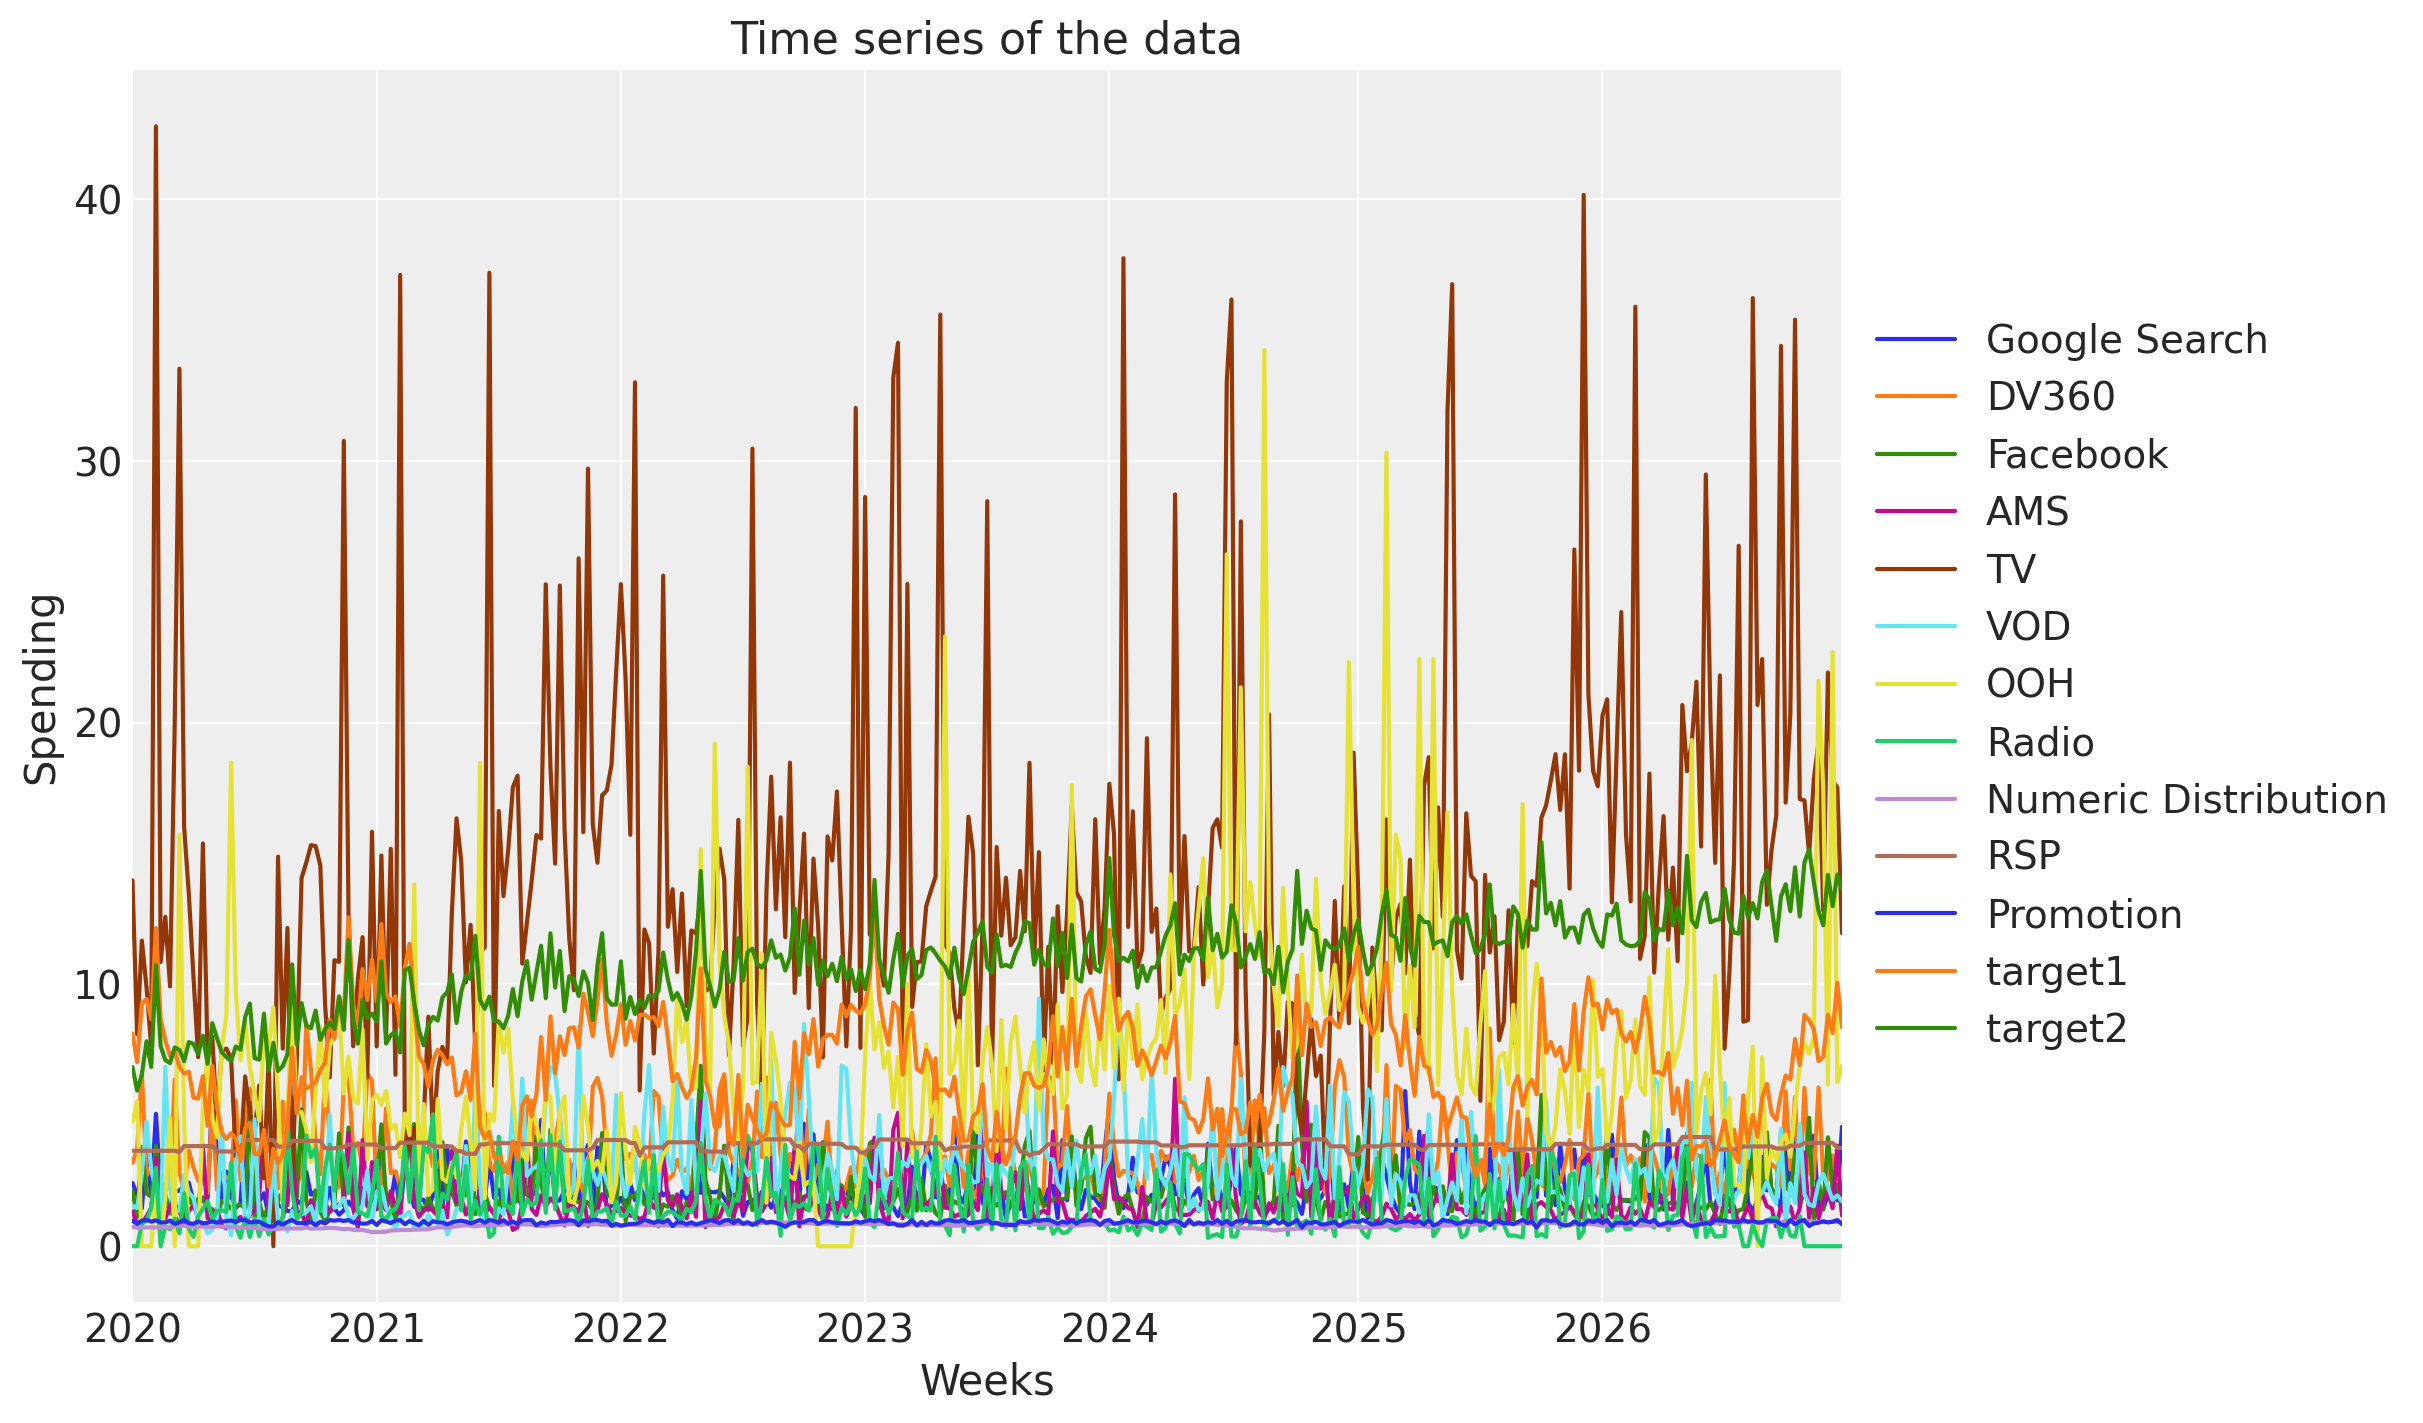

In [4]:
fig, ax = plt.subplots()
DATA.set_index("Weeks").plot(ax=ax)
ax.set_title("Time series of the data")
ax.set_ylabel("Spending")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

## Example 1: Yearly seasonality

A common pattern in consumer goods sales is that sales are higher in the summer and lower in the winter, or reverse. In this example, we will simulate sales that follow this pattern—by letting the synthetic intercept be a cosine wave—and then see if the model can recover this using a time-varying intercept.


#### → Simulate sales

The data we loaded did _not_ have a target variable. Instead, we simulate one, by **defining a model with fixed parameters**. We can do this using [the recently added `do` operator](https://www.pymc-labs.com/blog-posts/causal-analysis-with-pymc-answering-what-if-with-the-new-do-operator/) in `pymc`. In case you have not seen this trick before, take note because it's neat.


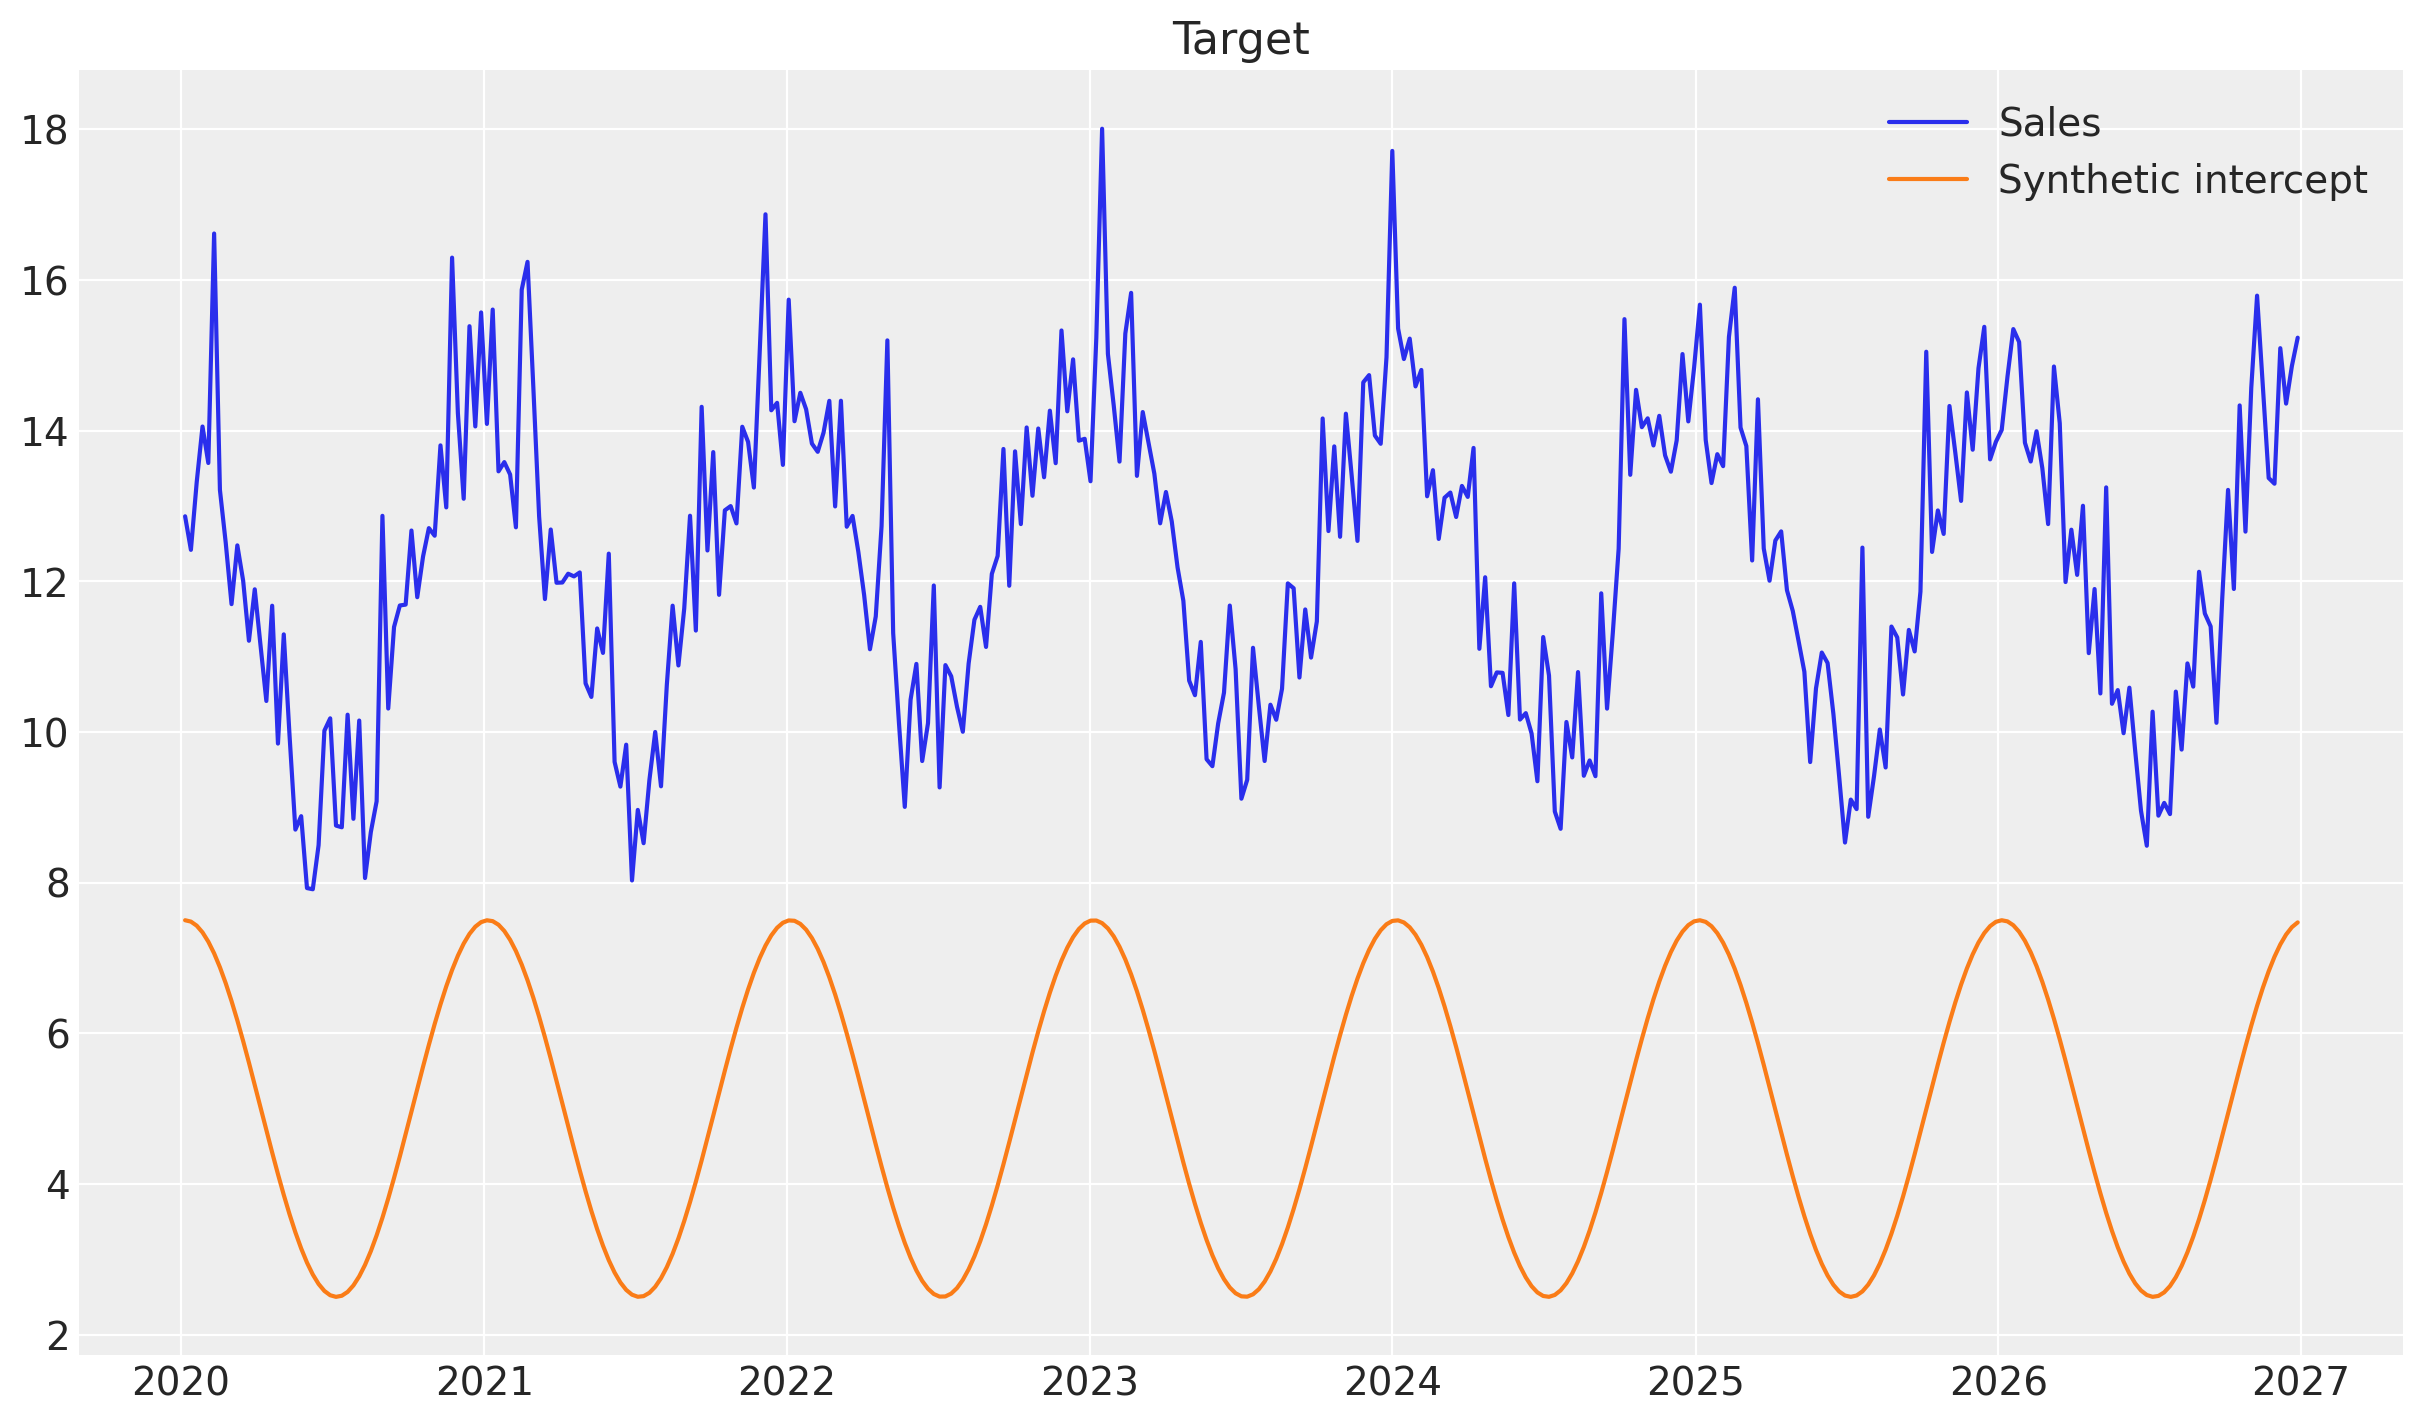

In [5]:
def synthesize_and_plot_target(synthetic_intercept: npt.NDArray) -> npt.NDArray:
    # Create the model, with channel spend, control variables, adstock, and yearly seasonality.
    # This model is **structurally identical** to the model we will fit a couple of cells below.
    mmm_synth = DelayedSaturatedMMM(
        date_column="Weeks",
        channel_columns=COORDS["media"],
        control_columns=COORDS["control"],
        adstock_max_lag=10,
        time_varying_intercept=True,
    )

    mmm_synth.build_model(DATA, np.ones(DATA.shape[0]))

    # Synthetic model parameters. These are largely arbitrary, though chosen to be somewhat realistic.
    synthetic_params = {
        "intercept": synthetic_intercept,
        "saturation_beta": np.array([3.5, 2.0, 5.0, 3.2, 1.5, 2.0, 1.0, 1.5]) * 4,
        "adstock_alpha": np.array([0, 0.5, 0.1, 0.1, 0.9, 0.5, 0.9, 0.95]),
        "saturation_lam": 1 / (DATA[COORDS["media"]].mean(0)).values,
        "y_sigma": 0.25,
    }

    # Manually set the model parameters. The `do` operator returns a new model where the parameters
    # which were supplied are deterministic.
    true_model = pm.do(
        mmm_synth.model,
        synthetic_params,
    )

    # Draw the target series from the model
    target = pm.draw(true_model.y, random_seed=SEED)

    # Plot the simulated target series
    fig, ax = plt.subplots()
    ax.set_title("Target")
    ax.plot(DATA.Weeks, target, label="Sales")
    ax.plot(DATA.Weeks, synthetic_intercept, label="Synthetic intercept")
    ax.legend()

    return target


# Define a synthetic time-varying intercept. In this first example, we set the intercept
# to be a cosine wave with a period of 52.18 weeks (1 year) which oscillates around 5.
N = DATA.shape[0]
synthetic_intercept_seasonal = (
    np.cos(2 * np.pi / 52.18 * np.arange(N)) / 2 + 1
) * 5  # 👈 Intercept that oscillates around 5

DATA["target_seasonal"] = synthesize_and_plot_target(synthetic_intercept_seasonal)

#### → Split into train and test

We split the data into _train_ and _test_ sets, so we may later display out-of-sample predictive performance.


In [6]:
SPLIT_N = 52
data_train = DATA.iloc[:-SPLIT_N]
data_test = DATA.iloc[-SPLIT_N:]

#### → Fit model
We fit the model with default settings, except specifying a `HalfNormal` prior on the baseline intercept. This is because we know that the baseline sales are positive, for a model like this.

In [7]:
def create_and_fit_MMM(data: pd.DataFrame, target: pd.Series) -> DelayedSaturatedMMM:
    mmm = DelayedSaturatedMMM(
        date_column="Weeks",
        channel_columns=COORDS["media"],
        control_columns=COORDS["control"],
        adstock_max_lag=10,
        time_varying_intercept=True,
        sampler_config={
            "chains": 4,
            "draws": 2000,
            "tune": 500,
            "nuts_sampler": "numpyro",
        },
    )
    mmm.model_config["intercept"]["dist"] = "HalfNormal"
    mmm.model_config["intercept"]["kwargs"] = {"sigma": 5}
    mmm.fit(data, target)
    return mmm


mmm_seasonal = create_and_fit_MMM(data_train, data_train["target_seasonal"])

Compiling.. :   0%|          | 0/2500 [00:00<?, ?it/s]








Running chain 0:   5%|▌         | 125/2500 [00:08<01:40, 23.66it/s]



Running chain 0:  10%|█         | 250/2500 [00:15<01:52, 19.94it/s]


Running chain 0:  15%|█▌        | 375/2500 [00:22<01:48, 19.65it/s]


Running chain 0:  20%|██        | 500/2500 [00:28<01:43, 19.37it/s]


Running chain 0:  25%|██▌       | 625/2500 [00:36<01:43, 18.20it/s]


Running chain 0:  30%|███       | 750/2500 [00:43<01:39, 17.57it/s]


Running chain 0:  35%|███▌      | 875/2500 [00:51<01:34, 17.18it/s]


Running chain 0:  40%|████      | 1000/2500 [00:59<01:28, 16.94it/s]


Running chain 0:  45%|████▌     | 1125/2500 [01:06<01:21, 16.77it/s]


Running chain 0:  50%|█████     | 1250/2500 [01:14<01:14, 16.67it/s]


Running chain 0:  55%|█████▌    | 1375/2500 [01:21<01:07, 16.60it/s]


Running chain 0:  60%|██████    | 1500/2500 [01:29<01:00, 16.56it/s]


Running chain 0:  65%|██████▌   | 1625/2500 [01:37<00:52, 16.52it/s]


Running chain 0:  70

#### → Posterior predictive checks

We visualize the posterior predictive distribution, to understand how well the model fits the data.


**Sales**

First, we consider predicted versus actual sales both within- and out-of-sample.


Sampling: [y]


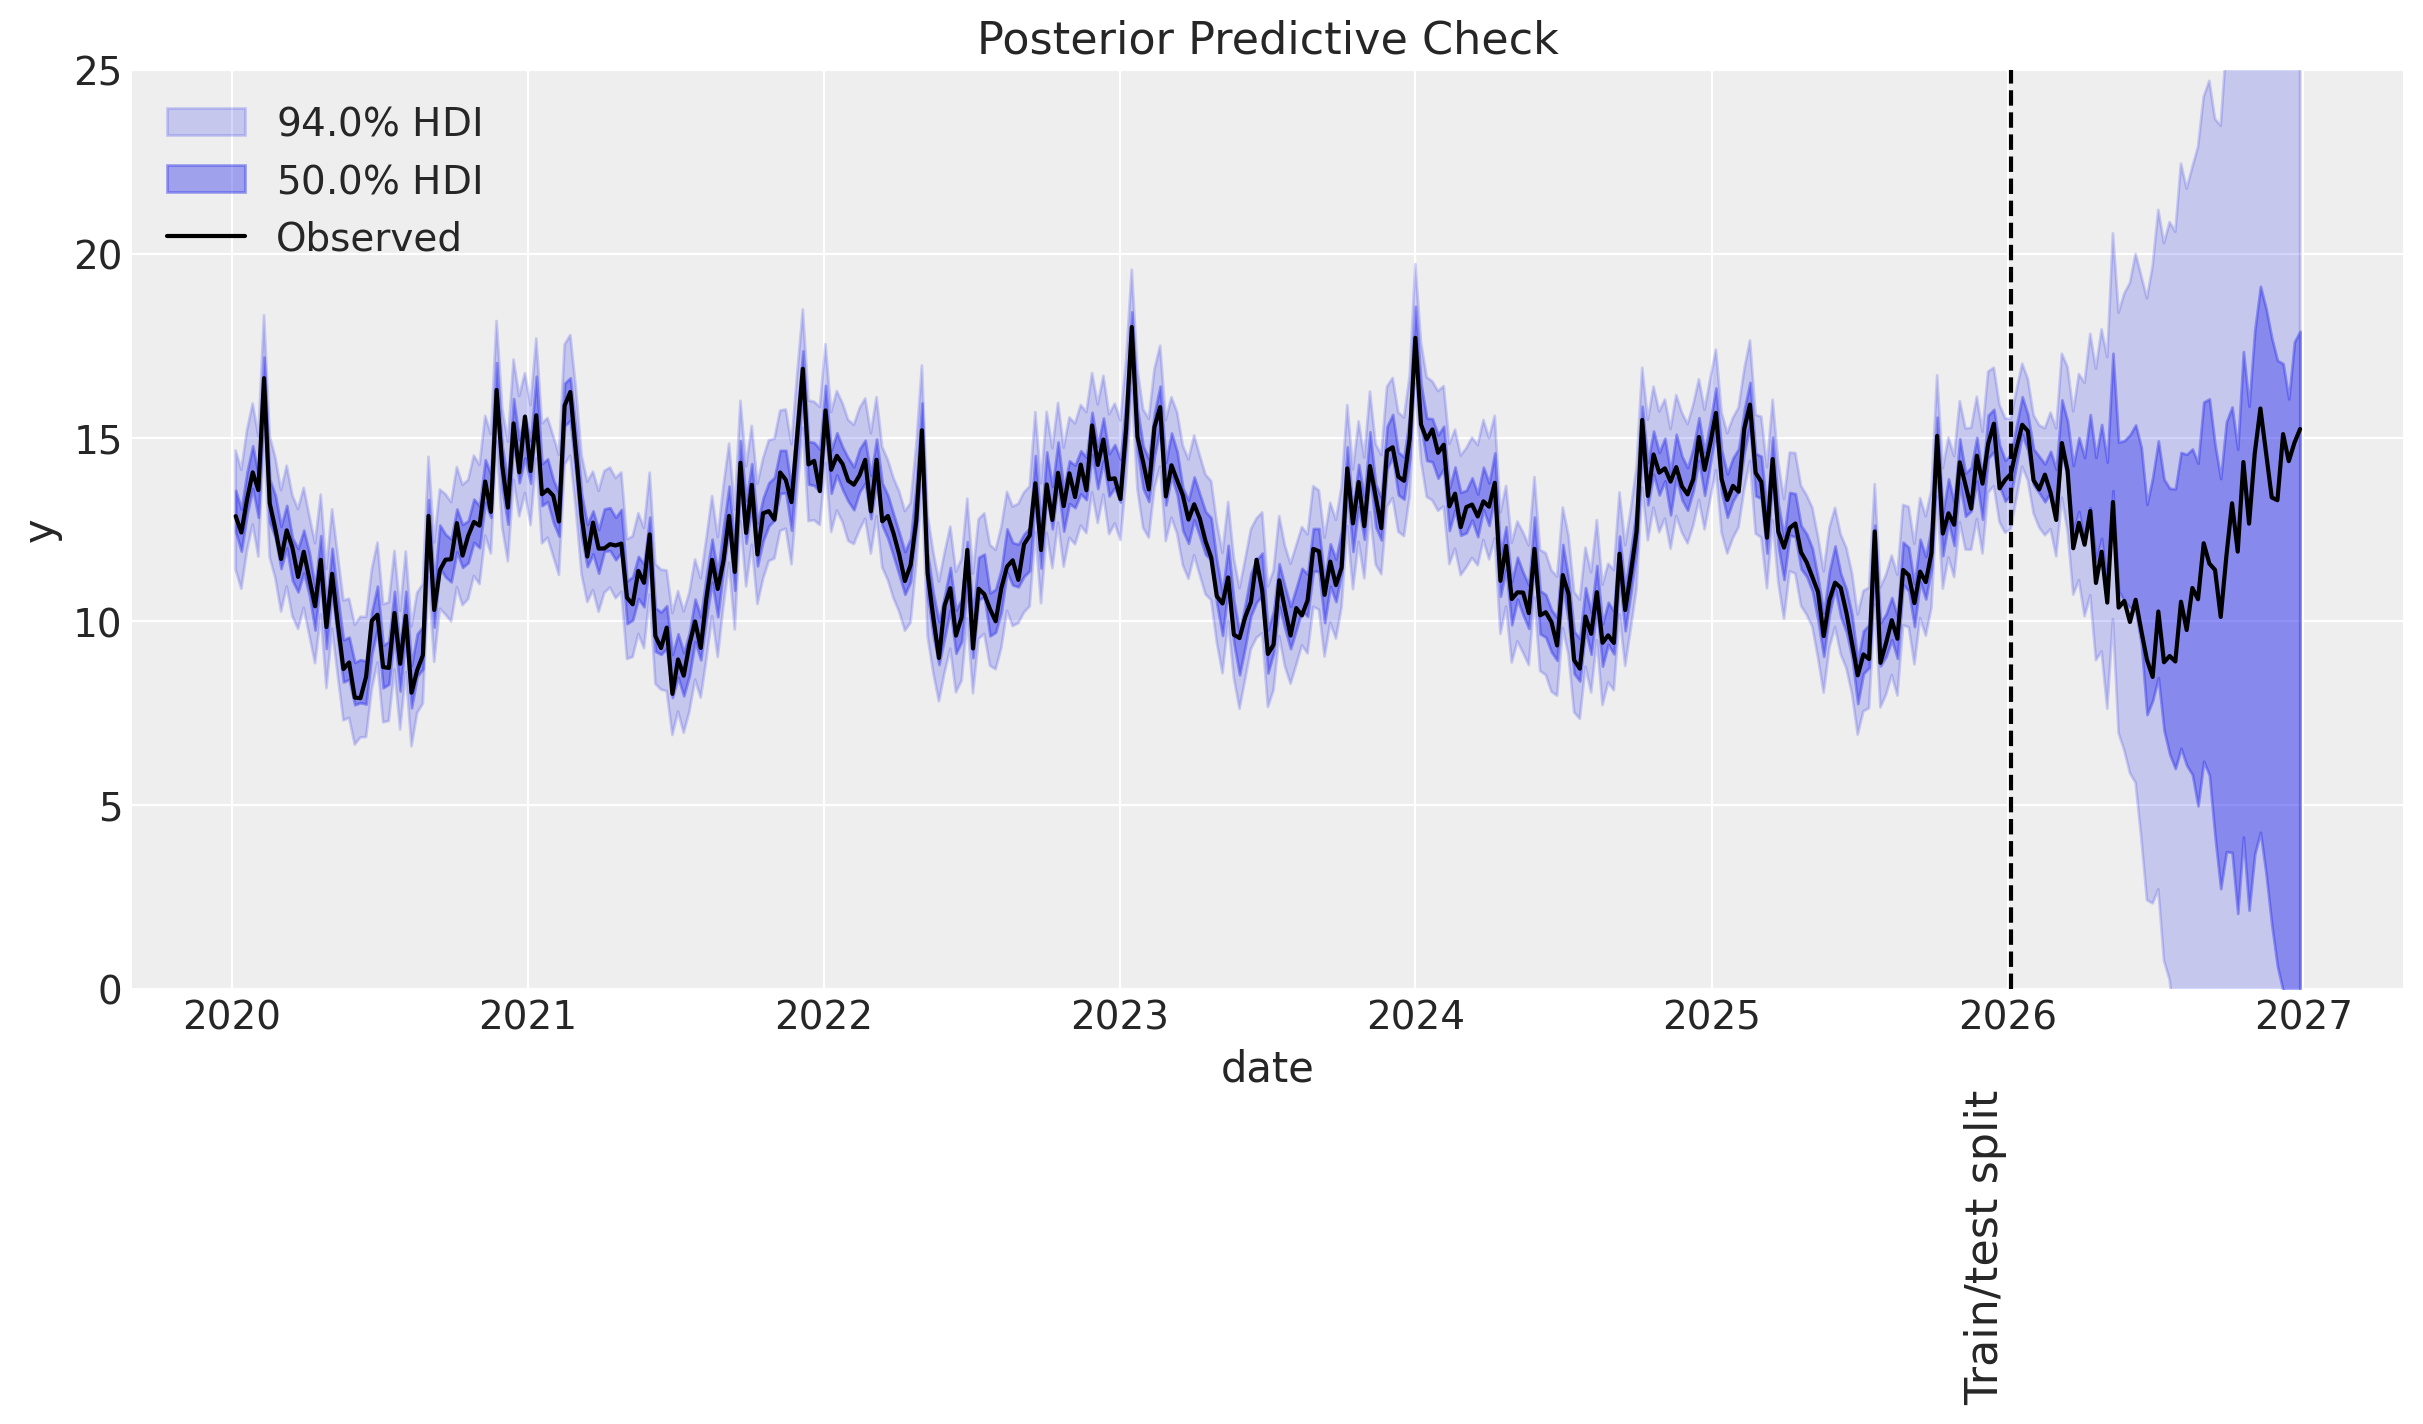

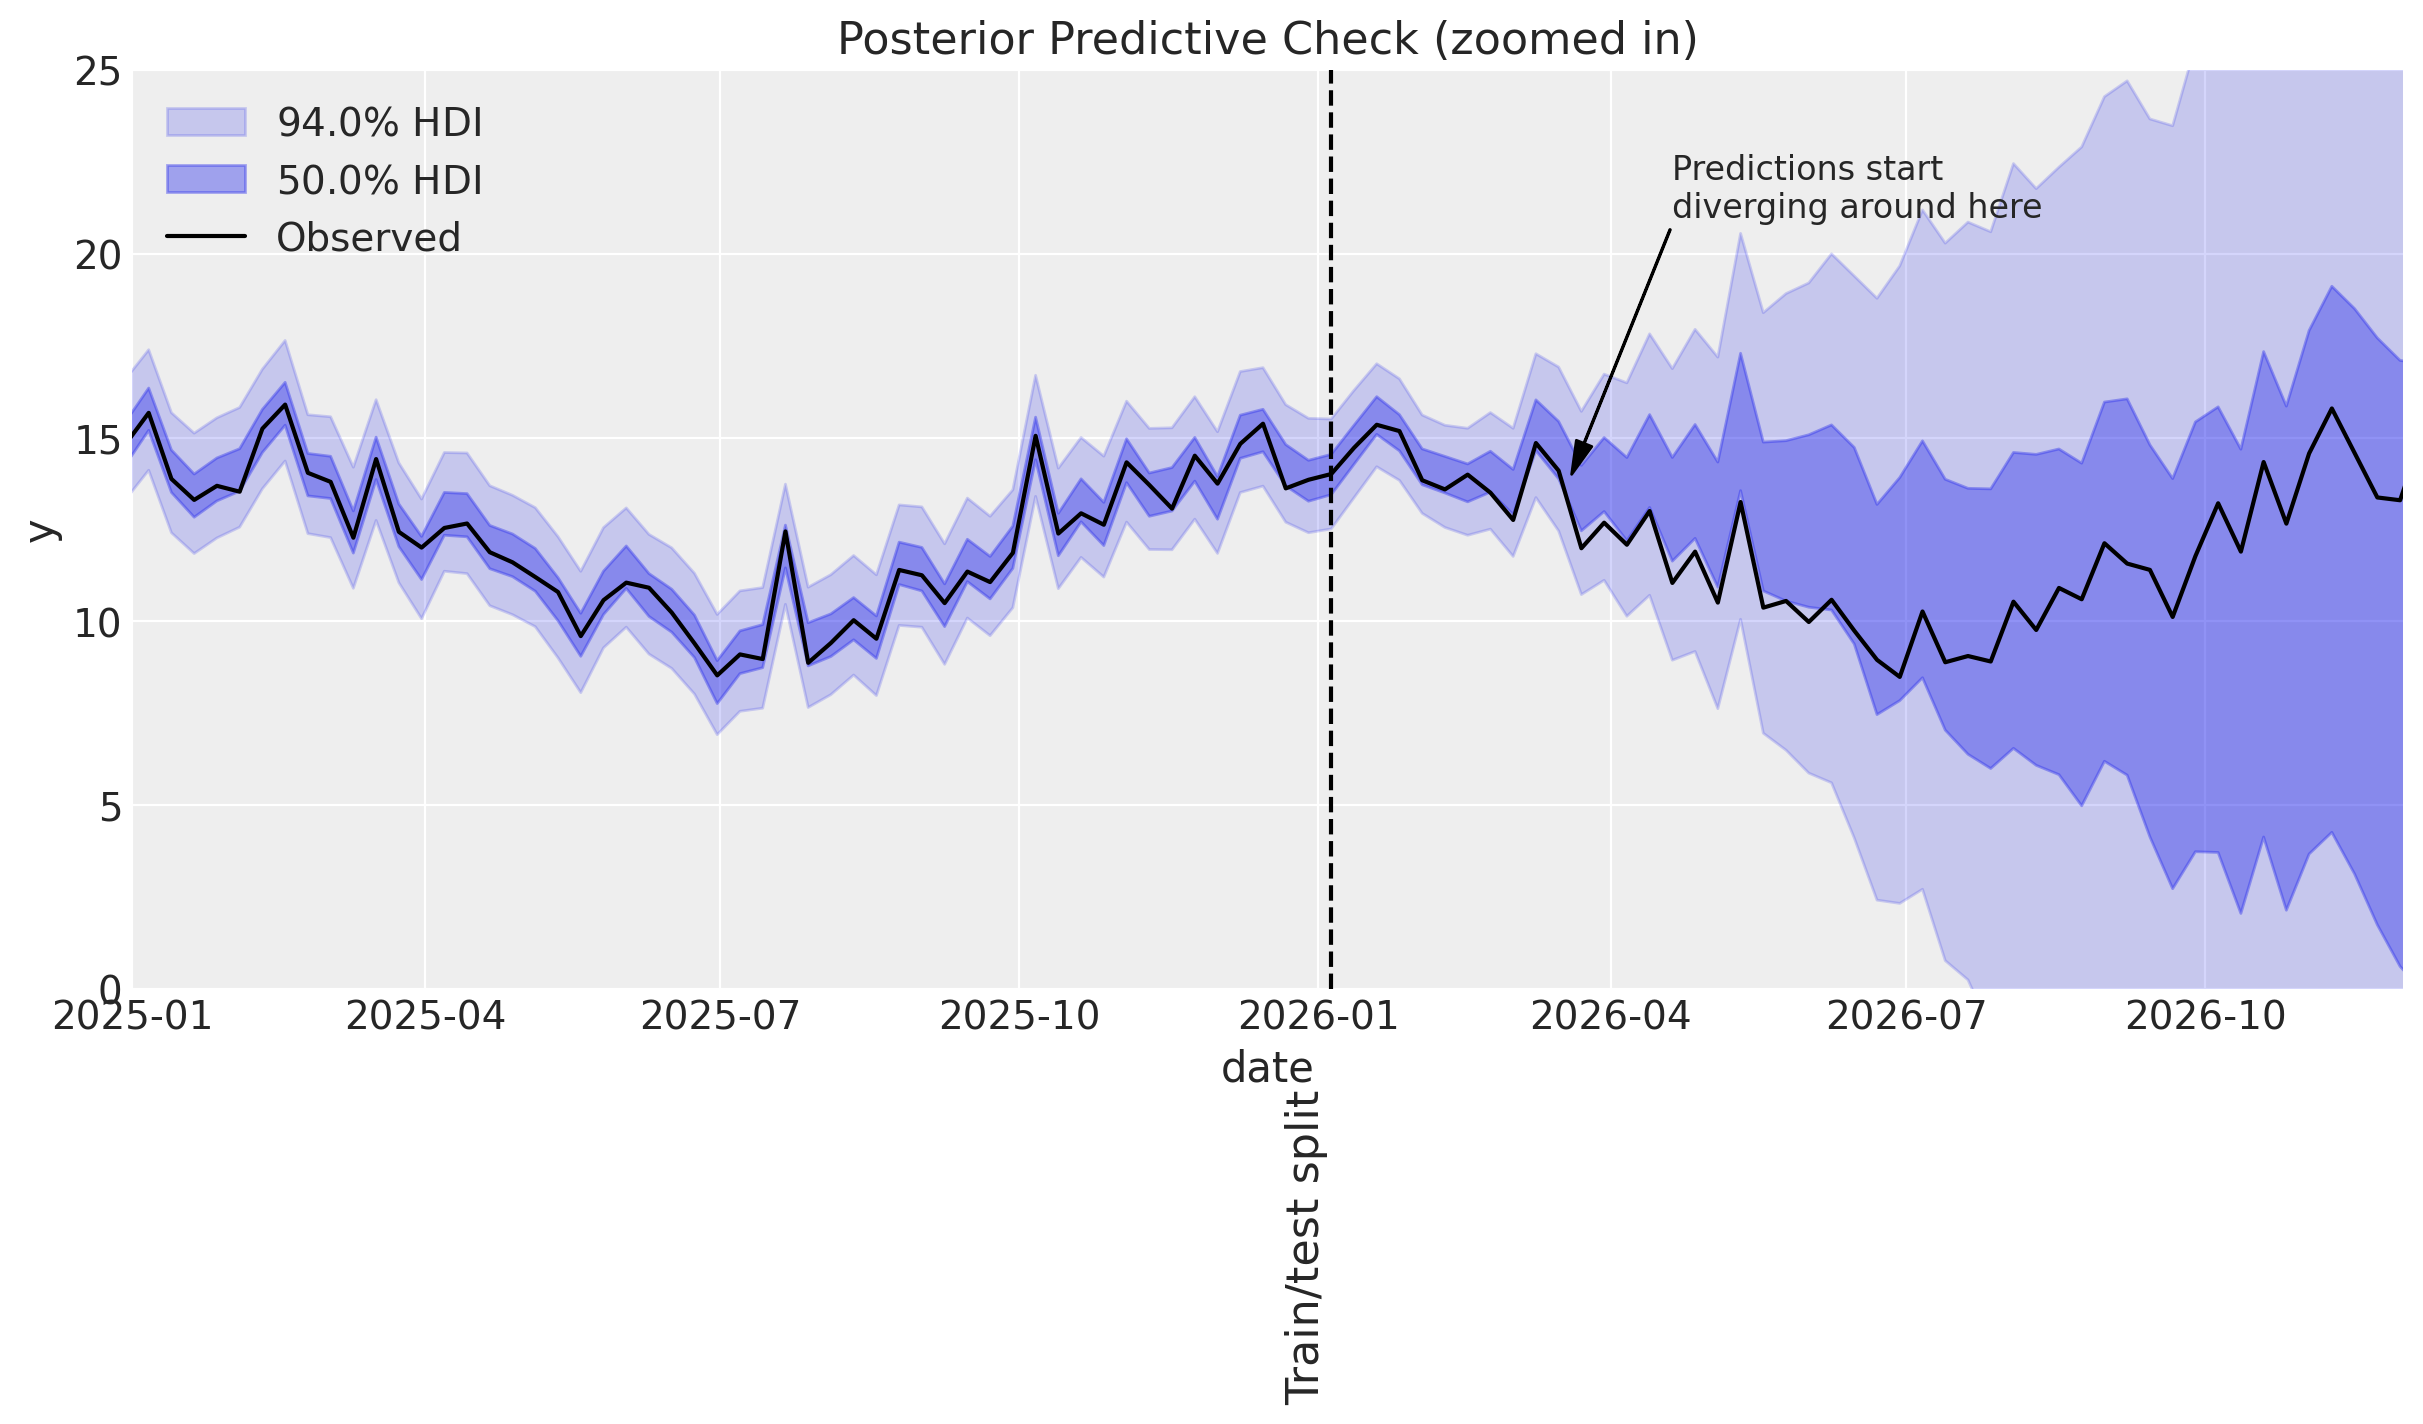

In [8]:
def plot_posterior_predictive(
    mmm: DelayedSaturatedMMM,
    target_series: pd.Series,
    label_y: float,
):
    # Sample posterior predictive in whole data range (train and test)
    if "posterior_predictive" not in mmm.idata:
        mmm.sample_posterior_predictive(
            X_pred=DATA, extend_idata=True, var_names=["y", "intercept"]
        )
    mmm.y = target_series.values

    # Plot the posterior predictive
    fig, ax = plt.subplots()
    mmm.plot_posterior_predictive(original_scale=True, ax=ax)
    split_index = DATA.shape[0] - SPLIT_N
    ax.axvline(
        mmm.posterior_predictive.date[split_index].values,
        color="black",
        linestyle="--",
    )
    ax.text(
        mmm.posterior_predictive.date[split_index].values,
        label_y,
        "Train/test split\n",
        verticalalignment="center",
        horizontalalignment="center",
        fontsize=16,
        rotation=90,
    )
    return ax


def plot_posterior_predictive_zoomed(
    mmm: DelayedSaturatedMMM,
    target_series: pd.Series,
    xlim: tuple[date, date],
    arrow_xy: tuple[date, float],
    arrowtext_xy: tuple[date, float],
    label_y: float,
    annotation_text="Predictions start\ndiverging around here",
):
    ax = plot_posterior_predictive(mmm, target_series, label_y)
    ax.set_title("Posterior Predictive Check (zoomed in)")
    ax.set_xlim(xlim)
    ax.annotate(
        annotation_text,
        xy=arrow_xy,
        xytext=arrowtext_xy,
        arrowprops=dict(facecolor="black", shrink=1, width=0.2, headwidth=6),
        fontsize=12,
    )
    return ax


# Plot the whole period
ax = plot_posterior_predictive(
    mmm_seasonal, DATA["target_seasonal"], label_y=-7
)
ax.set_ylim(0, 25)

# Zoom in on the years around the train/test split
ax = plot_posterior_predictive_zoomed(
    mmm_seasonal,
    DATA["target_seasonal"],
    xlim=(date(2025, 1, 1), date(2026, 12, 1)),
    arrow_xy=(date(2026, 3, 20), 14),
    arrowtext_xy=(date(2026, 4, 20), 21),
    label_y=-7,
)
ax.set_ylim(0, 25);

Some observations:

- 👍 The model performs well in-sample.
- 🤷‍♂️ The model predicts accurately up to ~3 months into the test set, then starts to deviate.

Since the most important utility of an MMM is to model the individual channel, control, and intercept contributions *in sample*, this out-of-sample error is not a particular worry. For scenario planning or backtesting, the decent performance in the 3 months after the training period ends, is likely sufficient, and in case a longer prediction window were desired, one would not want to use a GP to model seasonality, but rather a Fourier basis.

**Predicting intercept**

We can dig one step deeper, and display the posterior predictive distribution of the time-varying intercept. Let's first display the fitted baseline intercept (it should be close to 5).


In [9]:
def print_base_intercept(mmm):
    print(
        "base_intercept:",
        float(
            mmm.idata.posterior.base_intercept.mean()
            * mmm.target_transformer.steps[0][1].scale_[0]
        ),
    )


print_base_intercept(mmm_seasonal)

base_intercept: 4.676166469547709


🎉 That indeed is close to the true value of 5.

Now, let's visualize the posterior predictive distribution of the time-varying intercept, against the actual time-varying intercept.

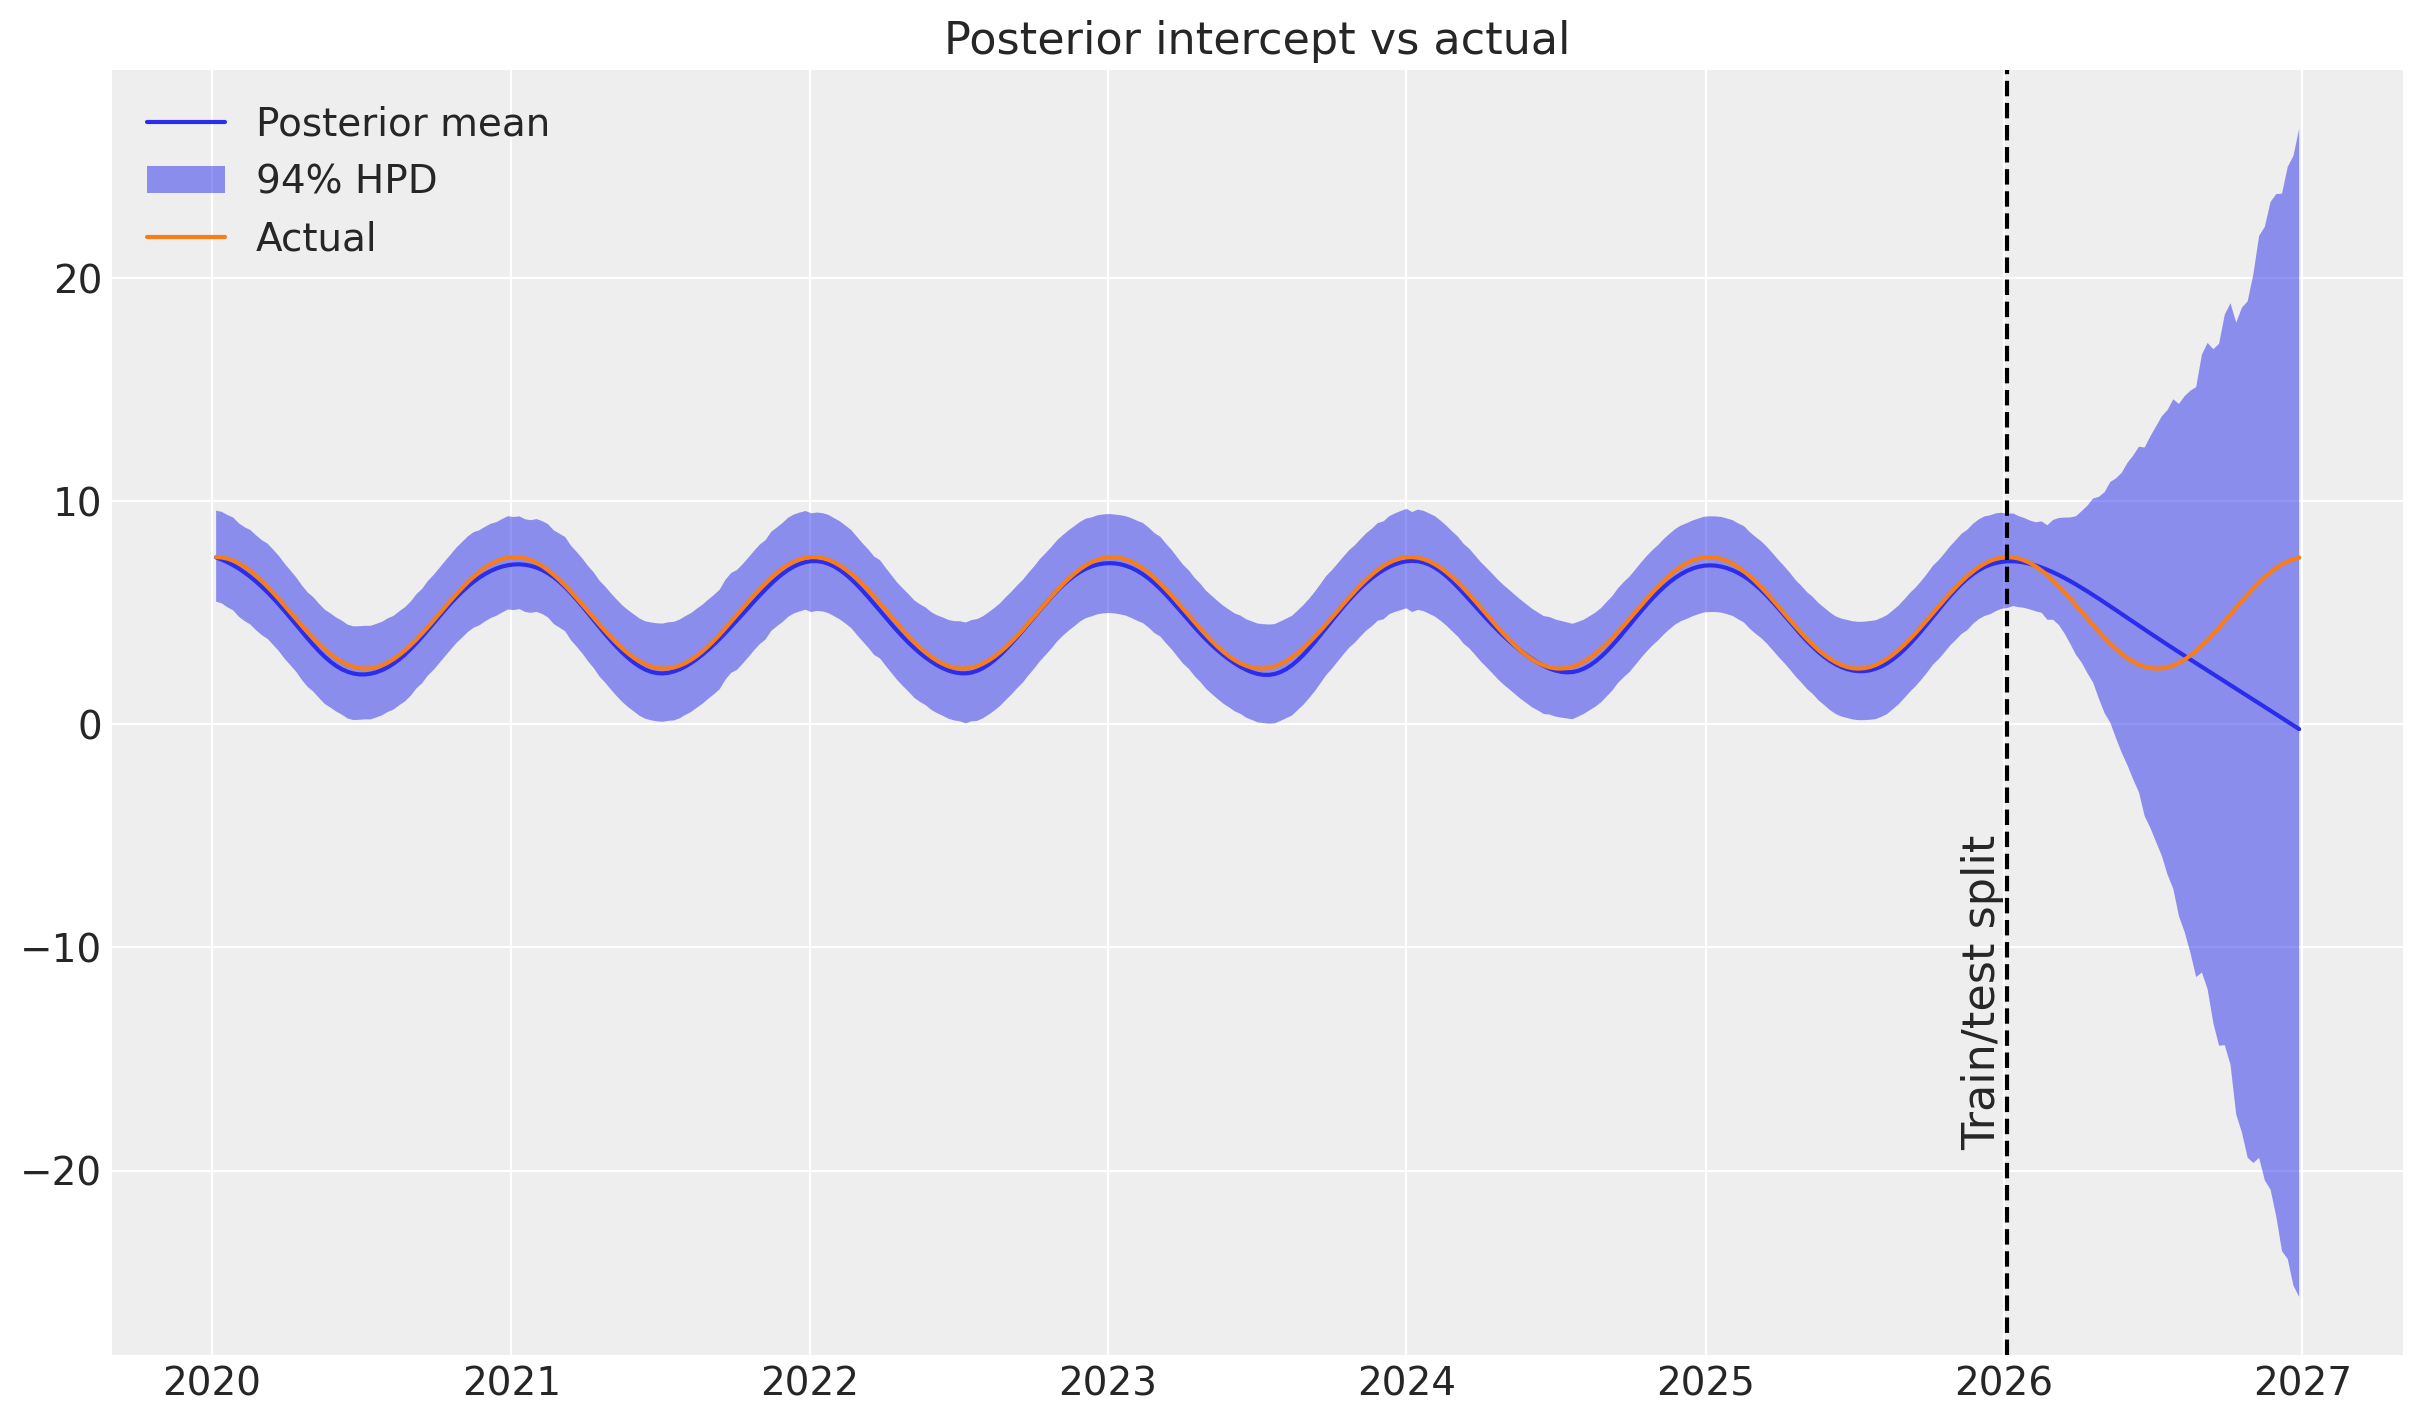

In [10]:
def plot_intercept_posterior_predictive(
    mmm: DelayedSaturatedMMM,
    synthetic_intercept: npt.NDArray[np.float_],
    label_y: float,
):
    # Get the posterior predictive of the intercept
    intercept_posterior_mean = mmm.target_transformer.inverse_transform(
        mmm.posterior_predictive.intercept.mean(axis=(0, 1)).data[:, None]
    )
    intercept_posterior_hpd = mmm.target_transformer.inverse_transform(
        az.hdi(mmm.posterior_predictive.intercept.values, hdi_prob=0.94)
    )

    # Plot posterior intercept versus actual
    fig, ax = plt.subplots()
    ax.set_title("Posterior intercept vs actual")
    ax.plot(
        mmm.posterior_predictive.date, intercept_posterior_mean, label="Posterior mean"
    )
    ax.fill_between(
        mmm.posterior_predictive.date,
        intercept_posterior_hpd[:, 0],
        intercept_posterior_hpd[:, 1],
        alpha=0.5,
        label="94% HPD",
    )
    ax.plot(mmm.posterior_predictive.date, synthetic_intercept, label="Actual")
    split_index = DATA.shape[0] - SPLIT_N
    ax.axvline(
        mmm.posterior_predictive.date[split_index].values,
        color="black",
        linestyle="--",
    )
    ax.text(
        mmm.posterior_predictive.date[split_index].values,
        label_y,
        "Train/test split\n",
        verticalalignment="center",
        horizontalalignment="center",
        fontsize=16,
        rotation=90,
    )
    ax.legend()
    return ax


plot_intercept_posterior_predictive(
    mmm_seasonal, synthetic_intercept_seasonal, label_y=-12
);

Visualizing this, it's clear that:

- 👌 In-sample it gets the synthetic trend almost exactly right!
- 👎 Out-of-sample, the uncertainty blows up. This is expected, as GPs are typically not great at extrapolating far from the training data. 

## Example 2: Upward trending sales

This section repeats the steps above, except with a linearly increasing intercept with mean 2.5, to mimic upward trending sales.

#### → Simulate sales


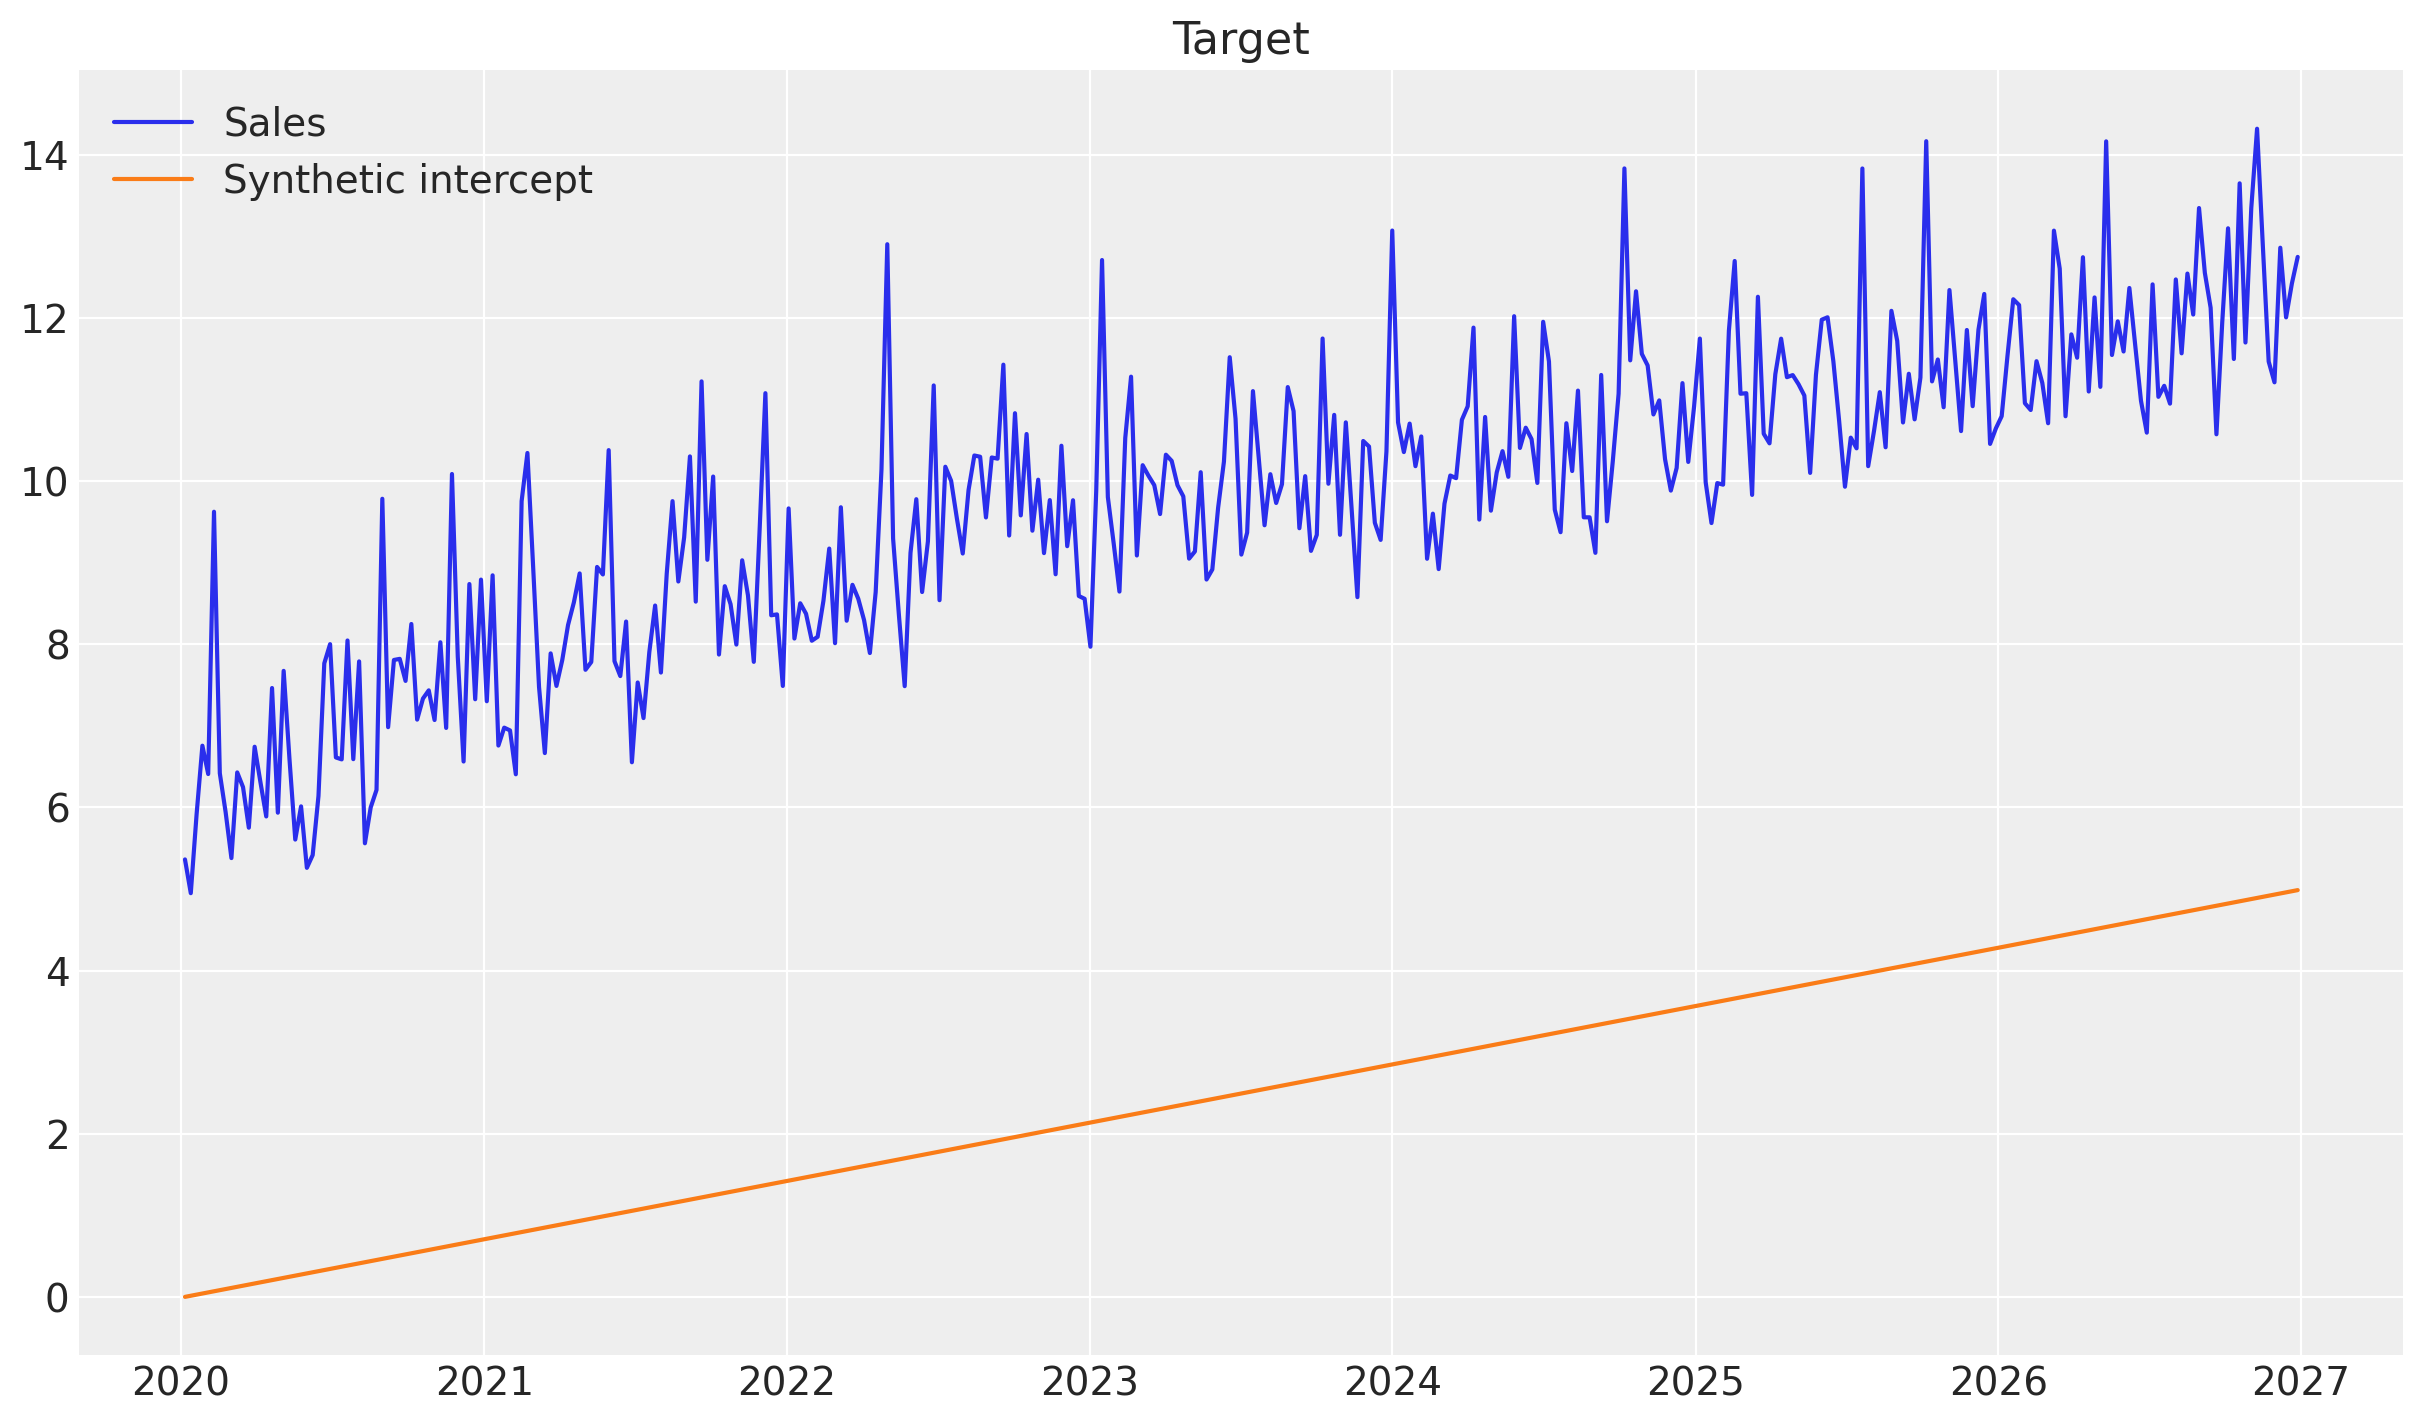

In [11]:
N = DATA.shape[0]
synthetic_intercept_upwards = np.arange(N) / N * 5

DATA["target_upwards"] = synthesize_and_plot_target(synthetic_intercept_upwards)

#### → Split into train and test


In [12]:
data_train = DATA.iloc[:-SPLIT_N]
data_test = DATA.iloc[-SPLIT_N:]

#### → Fit model


In [13]:
mmm_upwards = create_and_fit_MMM(data_train, data_train["target_upwards"])

Compiling.. :   0%|          | 0/2500 [00:00<?, ?it/s]








Running chain 0:   5%|▌         | 125/2500 [00:08<01:34, 25.21it/s]



Running chain 0:  10%|█         | 250/2500 [00:13<01:31, 24.59it/s]


Running chain 0:  15%|█▌        | 375/2500 [00:17<01:19, 26.82it/s]


Running chain 0:  20%|██        | 500/2500 [00:21<01:09, 28.62it/s]


Running chain 0:  25%|██▌       | 625/2500 [00:25<01:02, 30.01it/s]


Running chain 0:  30%|███       | 750/2500 [00:29<00:56, 30.93it/s]


Running chain 0:  35%|███▌      | 875/2500 [00:32<00:51, 31.54it/s]


Running chain 0:  40%|████      | 1000/2500 [00:36<00:47, 31.91it/s]


Running chain 0:  45%|████▌     | 1125/2500 [00:40<00:42, 32.11it/s]


Running chain 0:  50%|█████     | 1250/2500 [00:44<00:38, 32.28it/s]


Running chain 0:  55%|█████▌    | 1375/2500 [00:48<00:34, 32.39it/s]


Running chain 0:  60%|██████    | 1500/2500 [00:51<00:30, 32.48it/s]


Running chain 0:  65%|██████▌   | 1625/2500 [00:55<00:26, 32.55it/s]


Running chain 0:  70

#### → Posterior predictive check


**Predicting sales**

Sampling: [y]


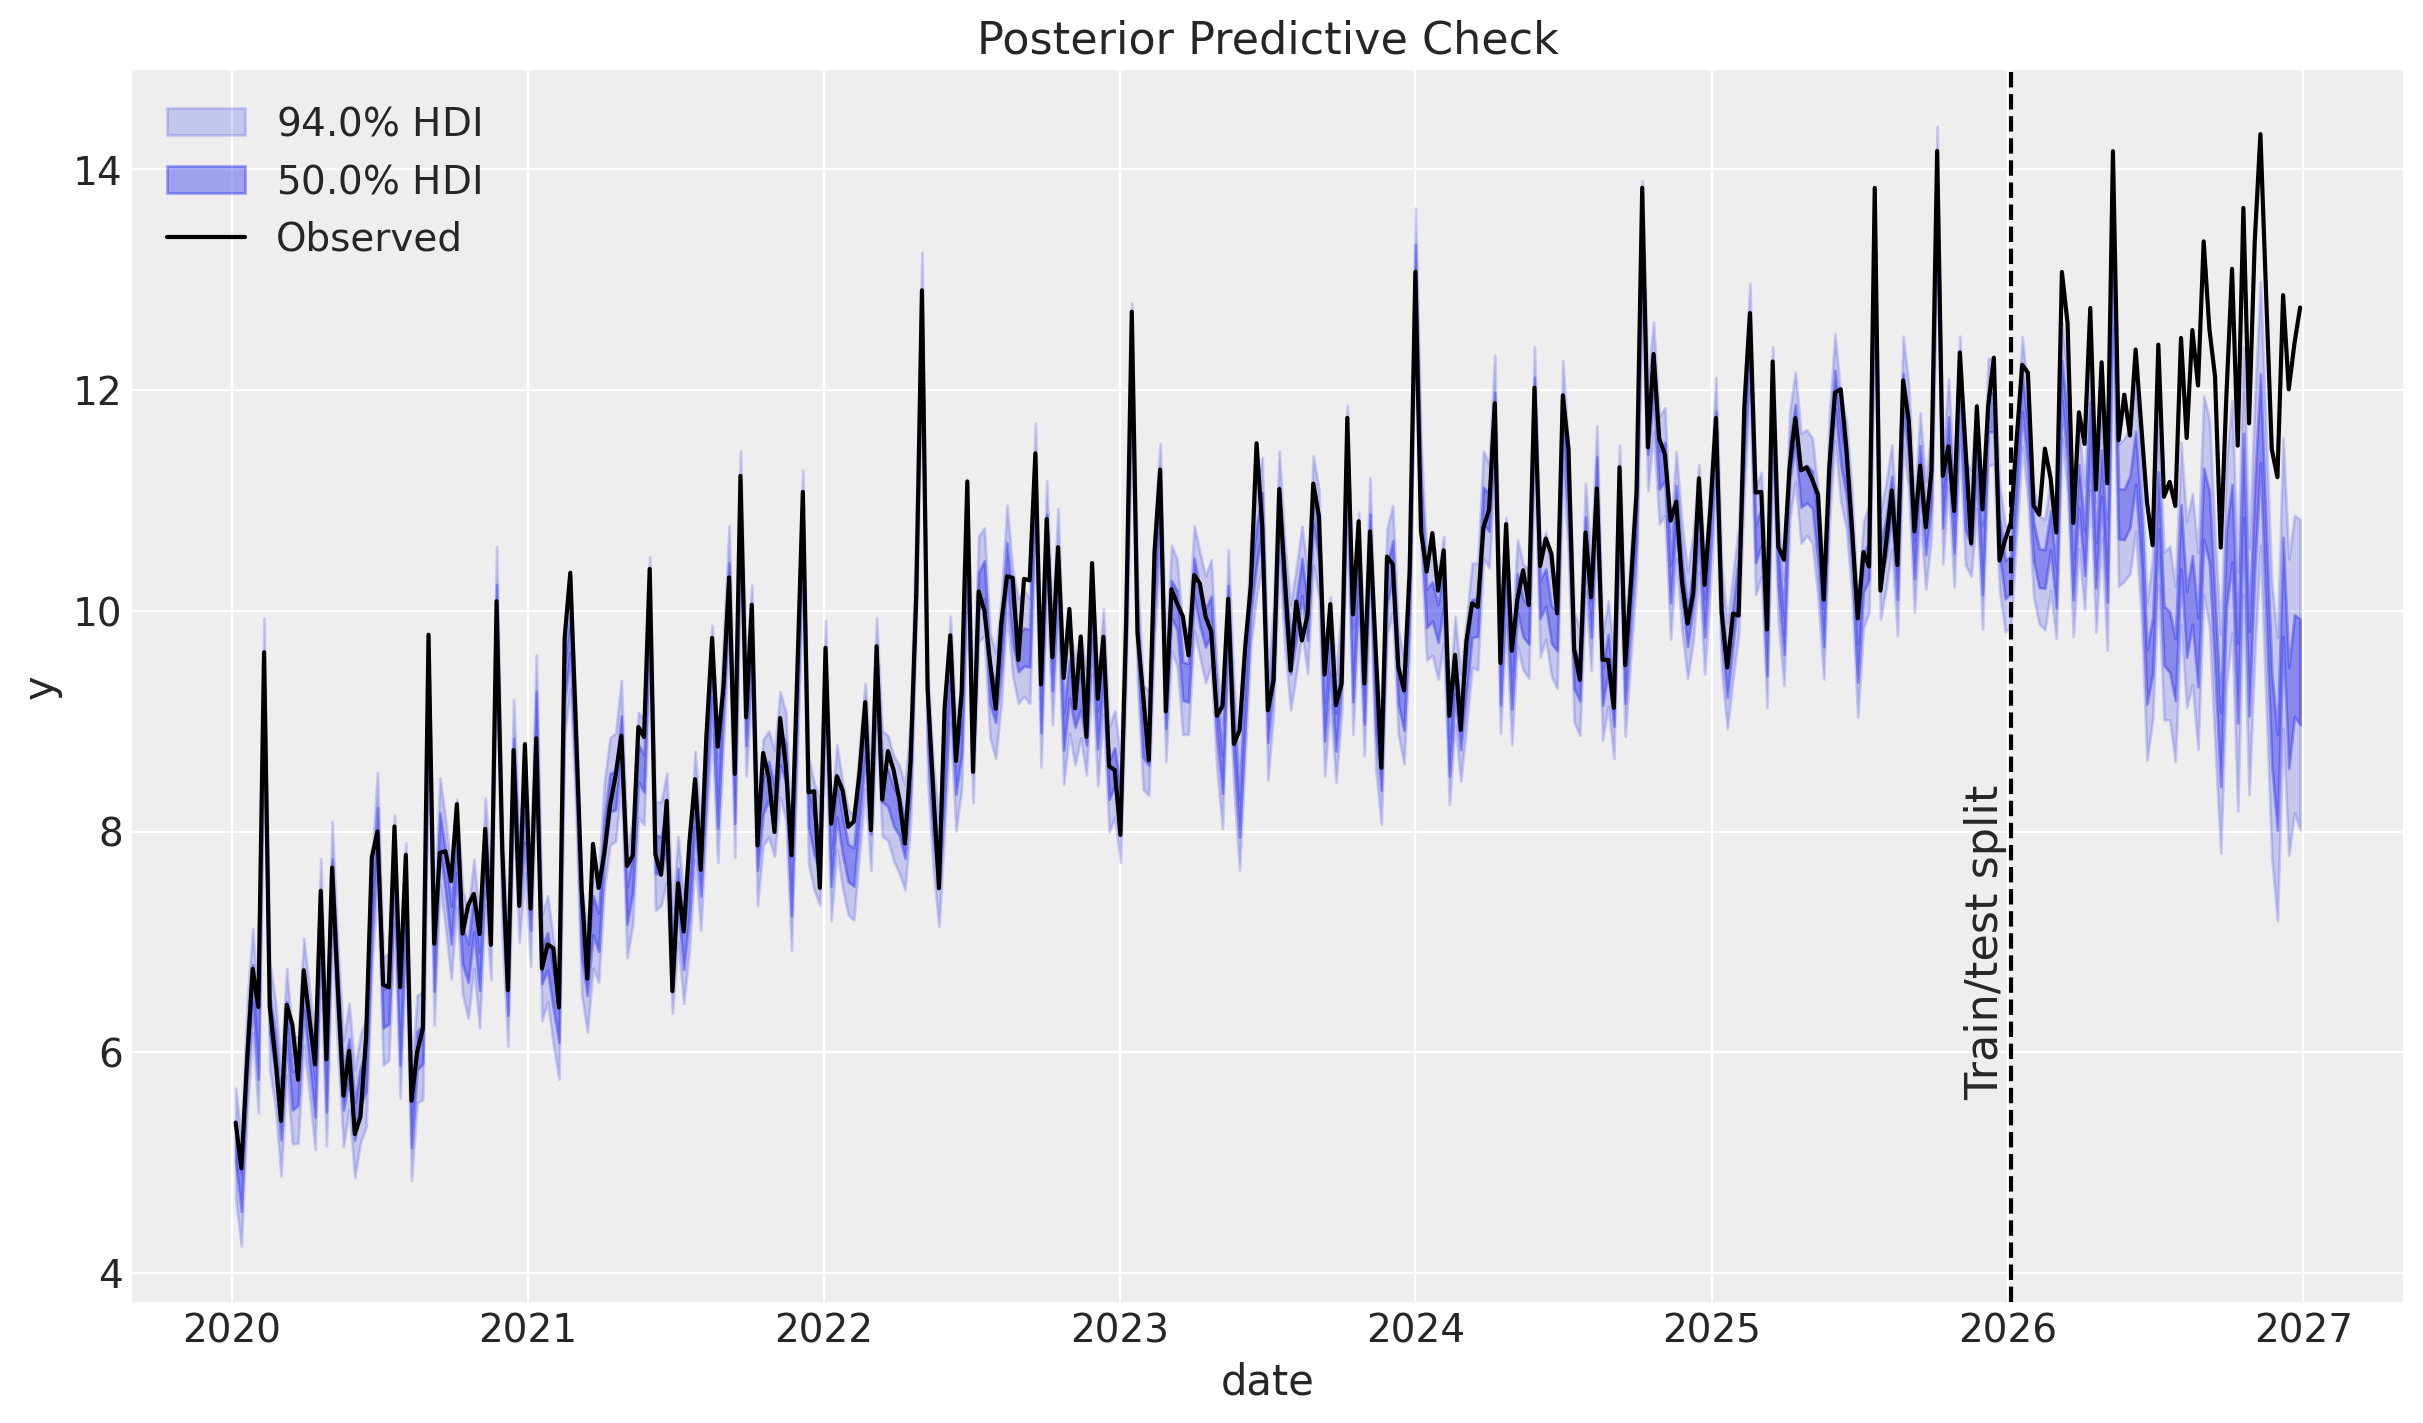

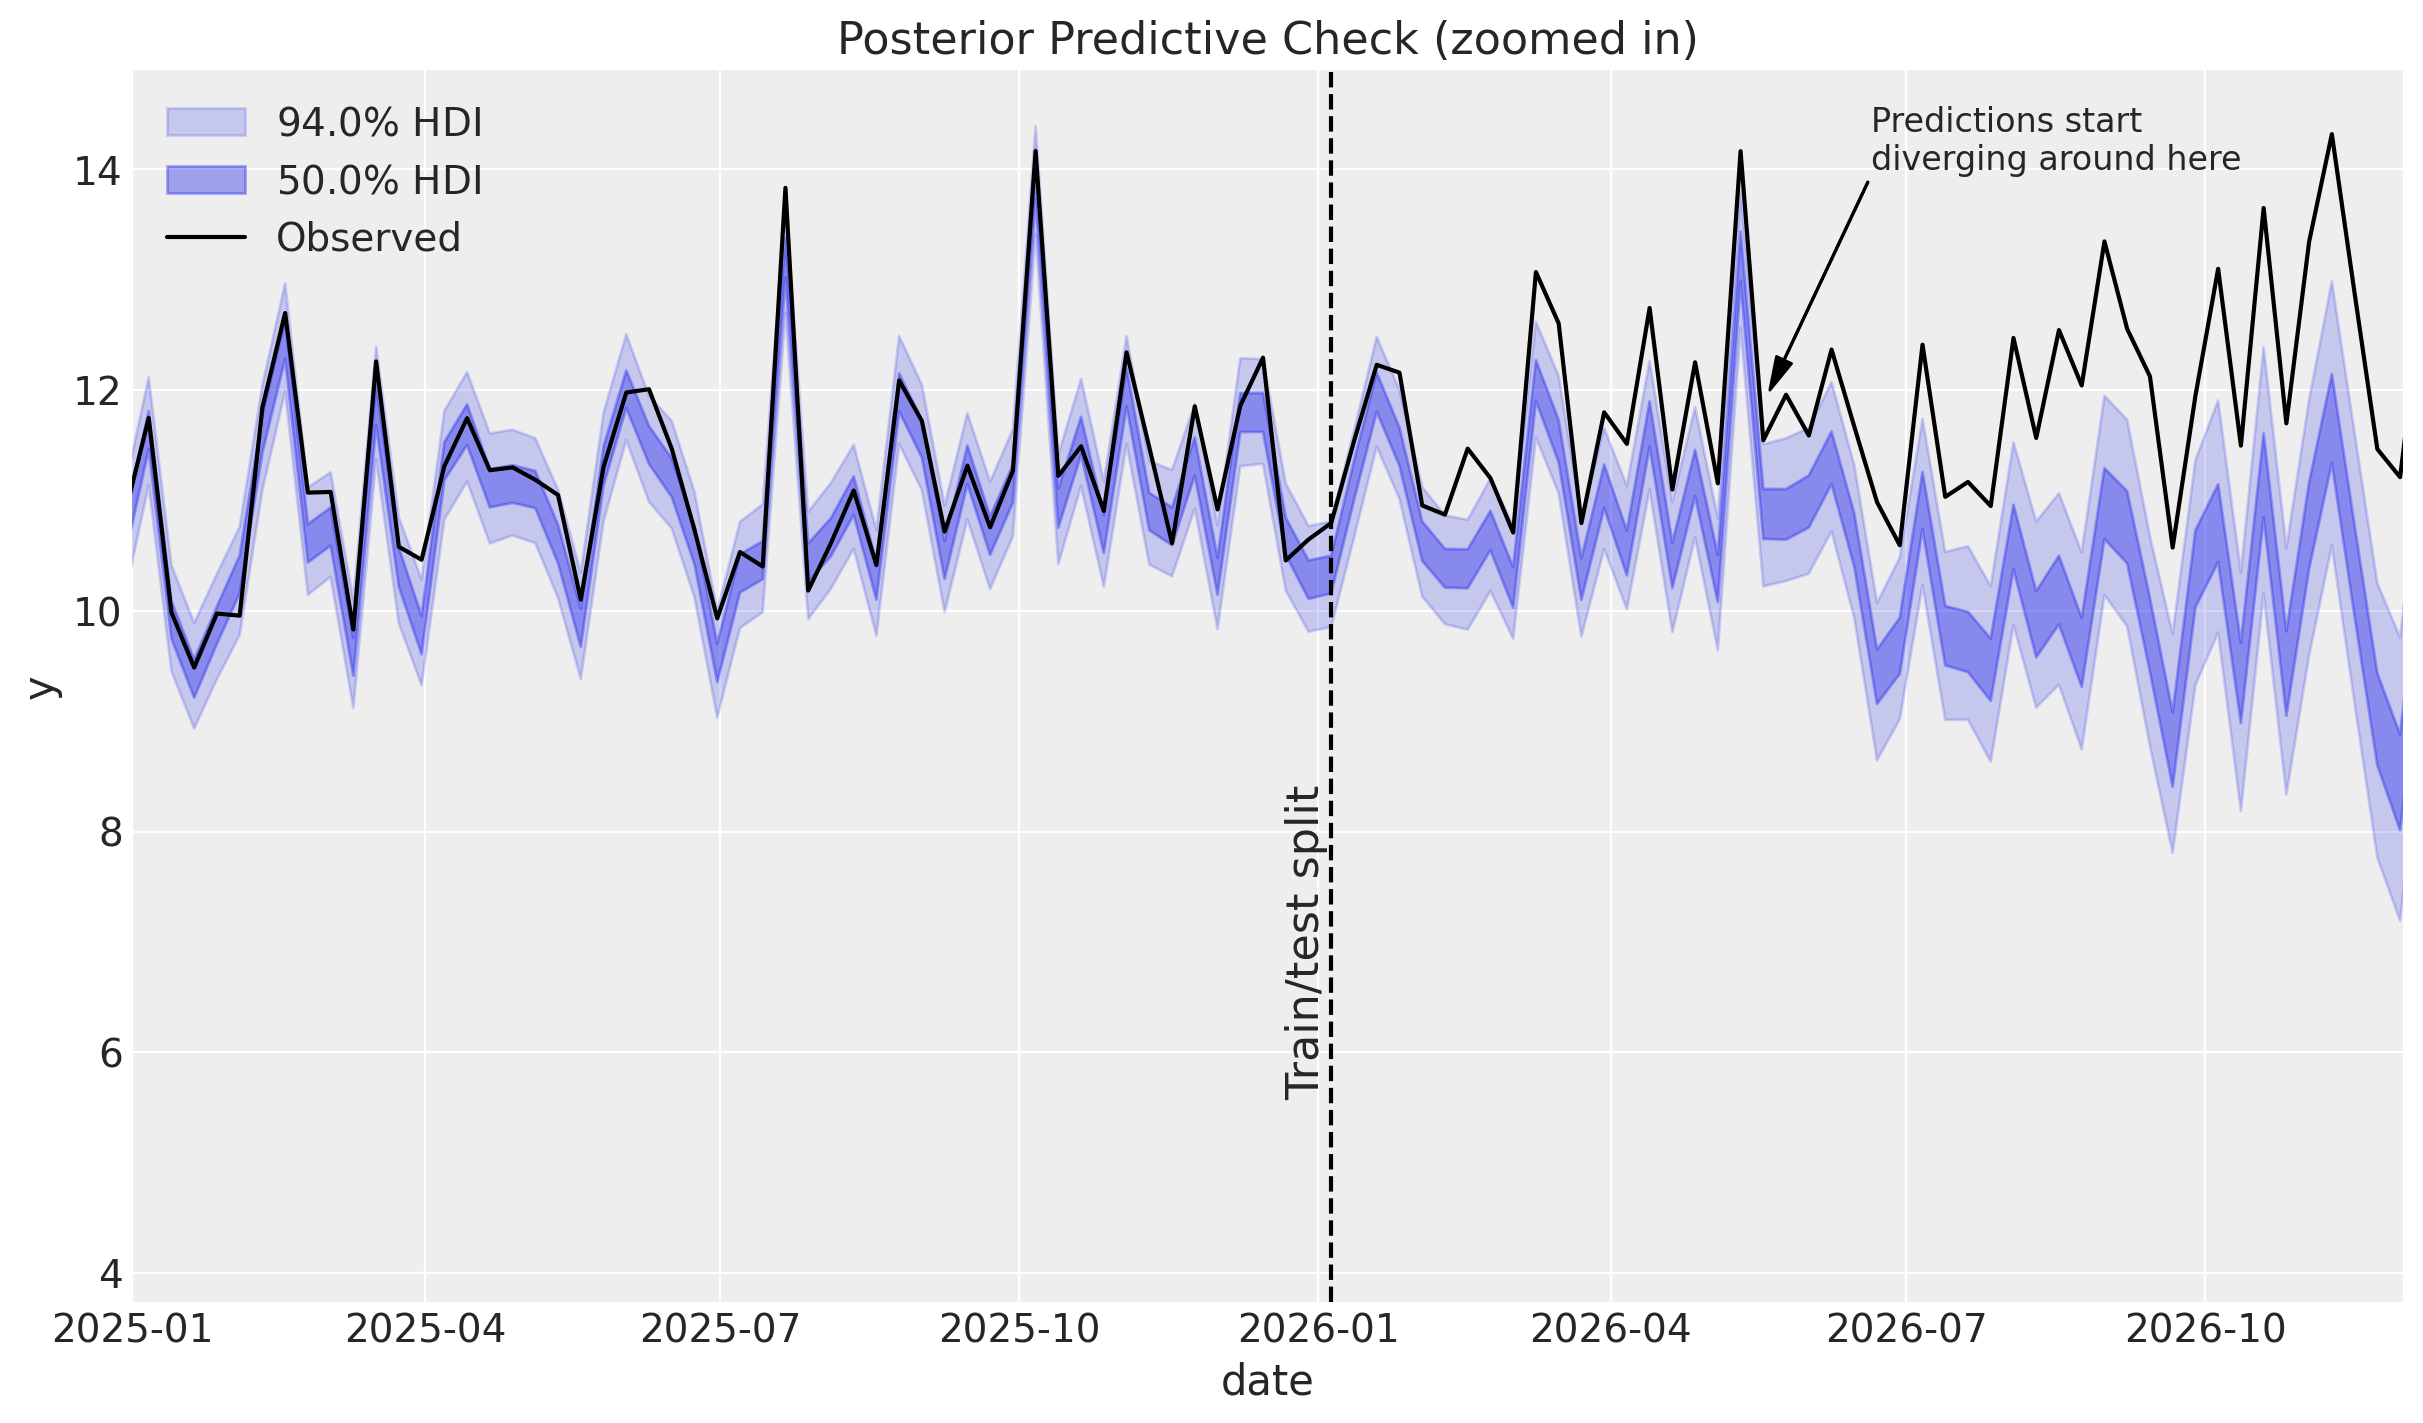

In [14]:
# Plot whole period
plot_posterior_predictive(mmm_upwards, DATA["target_upwards"], label_y=7)

# Zoom in on the years around train/test split
plot_posterior_predictive_zoomed(
    mmm_upwards,
    DATA["target_upwards"],
    xlim=(date(2025, 1, 1), date(2026, 12, 1)),
    arrow_xy=(date(2026, 5, 20), 12),
    arrowtext_xy=(date(2026, 6, 20), 14),
    label_y=7,
);

Observations:

- 👍 As seen previously, the model performs well in-sample.
- 👎 Similar to before, predictions are accurate up to ~3-6 months into the test set, then start to deviate. 

**Predicting intercept**

base_intercept: 1.0245830404276184


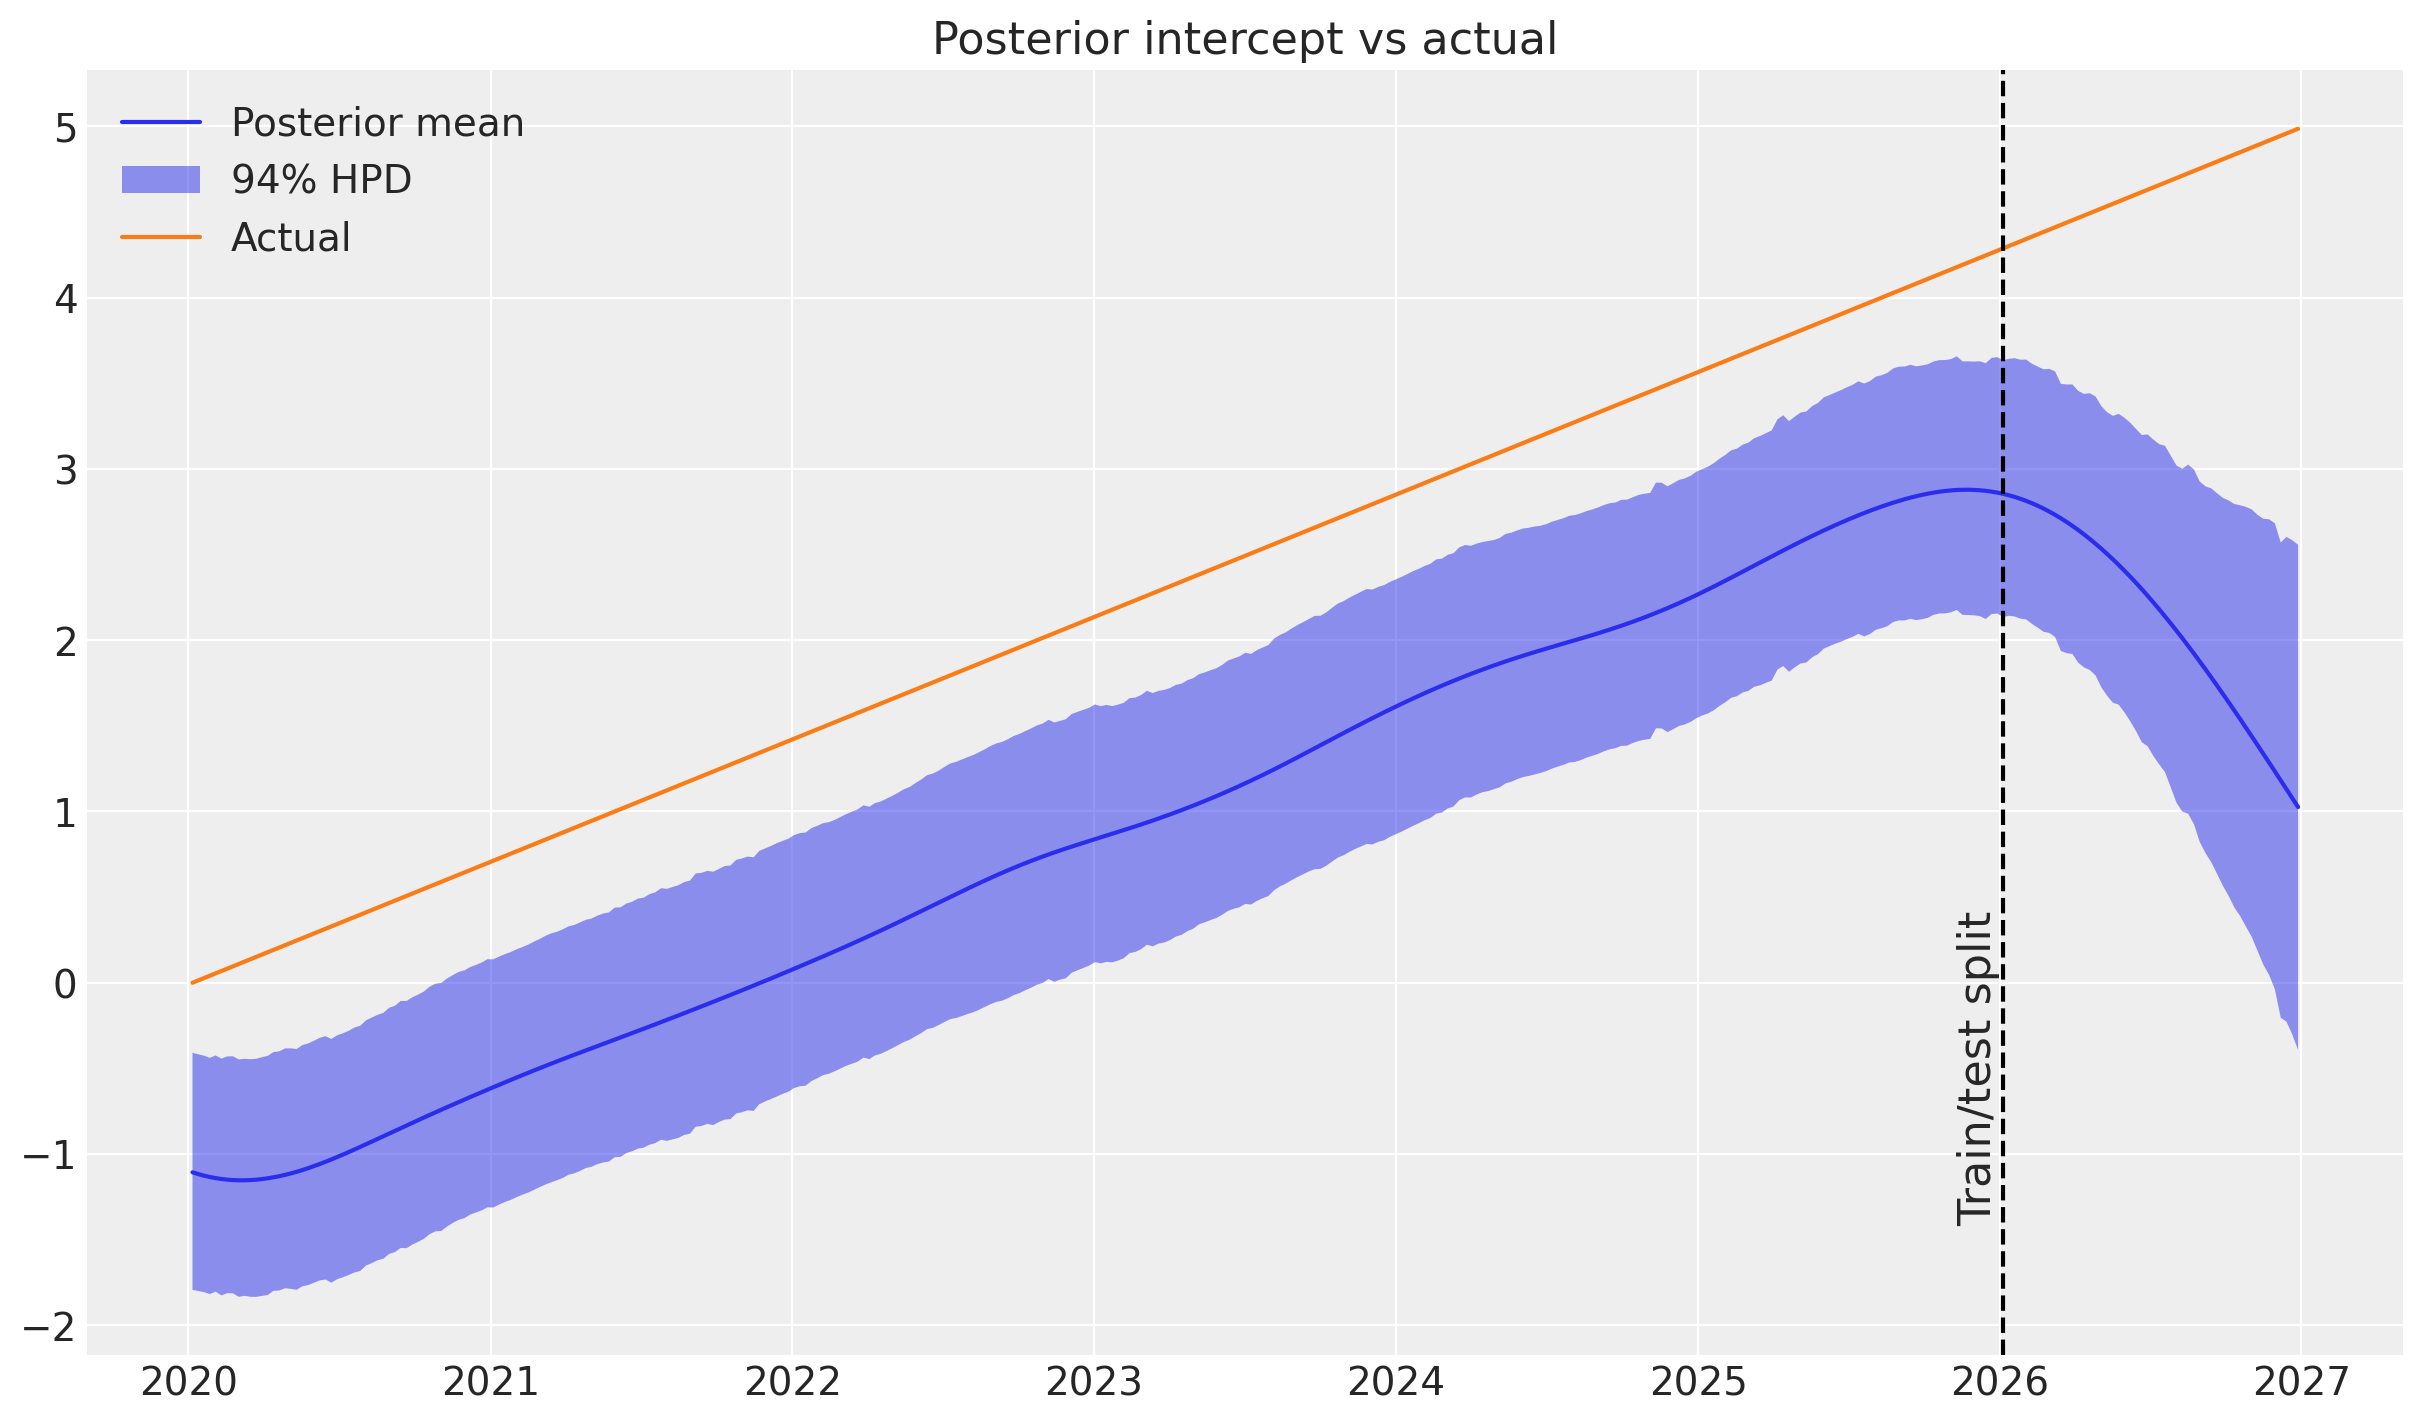

In [15]:
print_base_intercept(mmm_upwards)
plot_intercept_posterior_predictive(mmm_upwards, synthetic_intercept_upwards, label_y=-0.5);

Observations:

- 👎 In-sample it follows the synthetic trend but with an offset of about -1.5.
- 👎 Out-of-sample, the GP reverts to its prior mean.

It's quite clear from this example, that if you have a steep upward trend in your sales data that you have reason to expect will continue, you probably *should not* use a GP to model the intercept. Instead, you may use linearly increasing control variables.


## Example 3: Unexpected events

This section repeats the procedure except with an intercept of 5, except with intermittent spike/dip events. Each event could be a competitor product launch, a global pandemic, an unusually sunny spring, or another impactful, unexpected event.


#### → Simulate sales


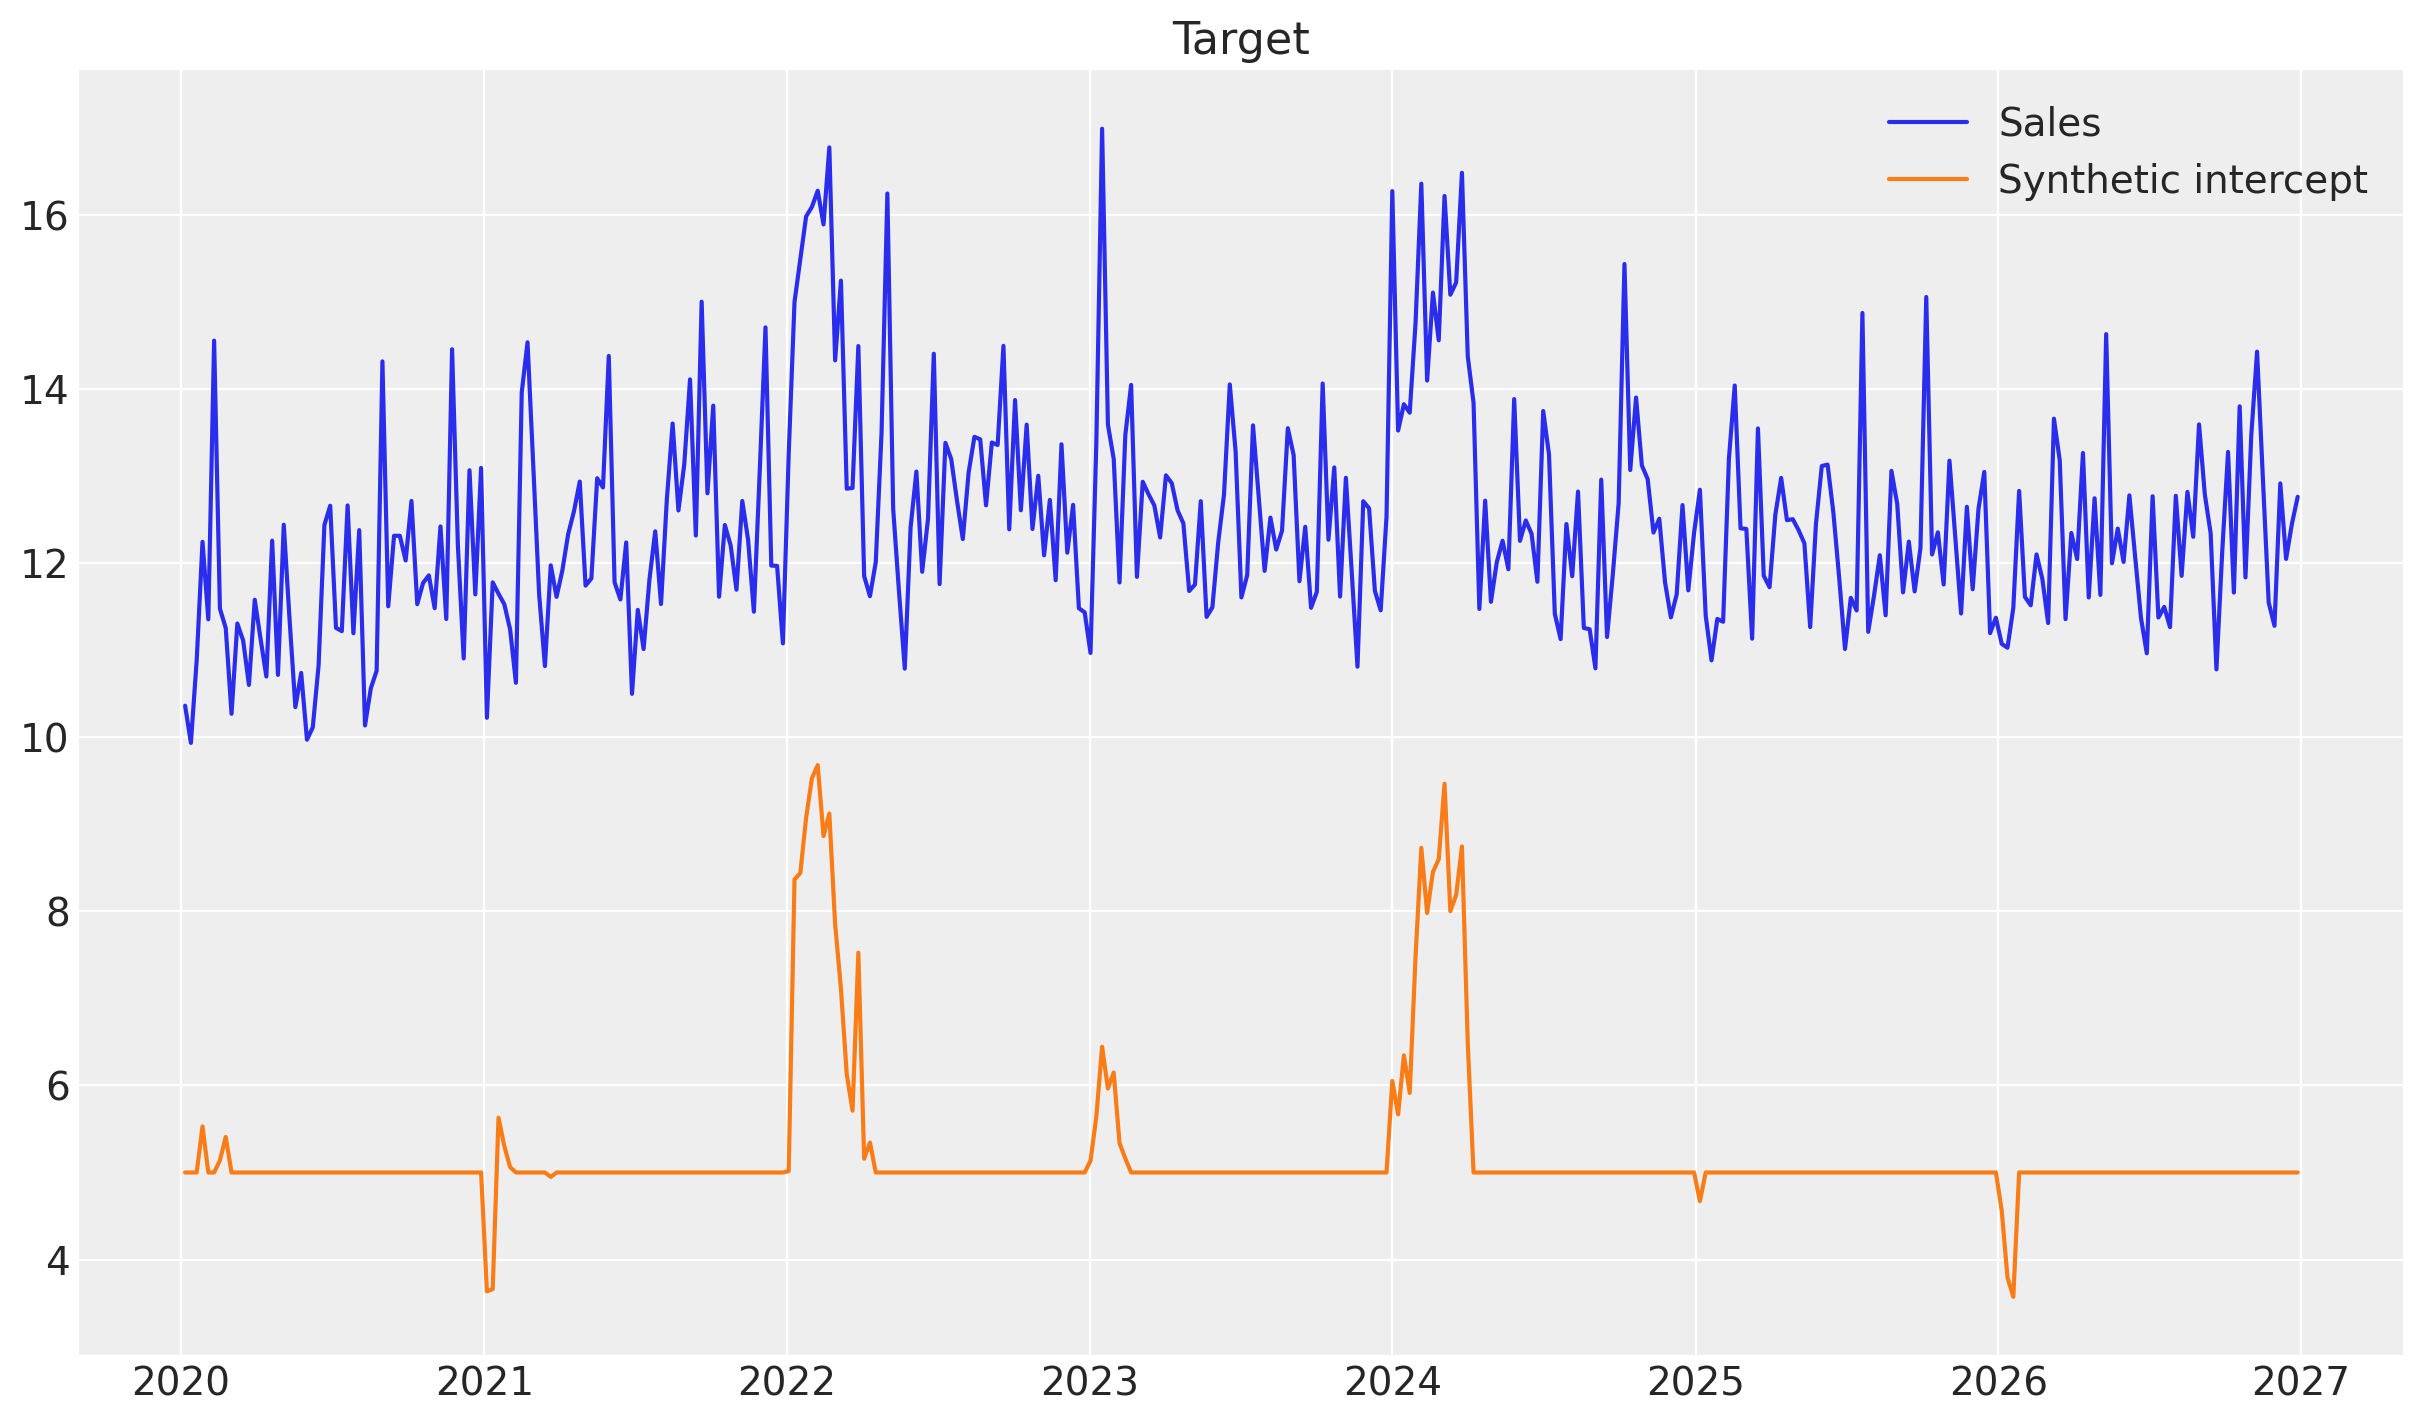

In [16]:
def create_yearly_series() -> npt.NDArray:
    np.random.seed(42)

    # Get the number of weeks in each year
    weeks_in_years = DATA.Weeks.dt.year.value_counts().sort_index()

    # Create a flat and occasionally spiky time-series, in one-year increments
    series = np.zeros(sum(weeks_in_years))
    for i, num_weeks in enumerate(weeks_in_years):
        # Random spikes in sales
        series[sum(weeks_in_years[:i]) : sum(weeks_in_years[: i + 1])] = (
            (np.random.normal(size=num_weeks) - 0.5).cumsum().clip(0)
        )
        # Random dips in sales
        series[sum(weeks_in_years[:i]) : sum(weeks_in_years[: i + 1])] += -(
            (np.random.normal(size=num_weeks) - 0.5).cumsum().clip(0)
        )
    return series


synthetic_intercept_events = create_yearly_series() + 5

DATA["target_events"] = synthesize_and_plot_target(synthetic_intercept_events)

#### → Split into train and test


In [17]:
data_train = DATA.iloc[:-SPLIT_N]
data_test = DATA.iloc[-SPLIT_N:]

#### → Fit model


In [18]:
mmm_events = create_and_fit_MMM(data_train, data_train["target_events"])

Compiling.. :   0%|          | 0/2500 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2500 [00:03<?, ?it/s]


Running chain 0:   5%|▌         | 125/2500 [00:08<01:39, 23.87it/s]


Running chain 0:  10%|█         | 250/2500 [00:15<01:47, 20.96it/s]


Running chain 0:  15%|█▌        | 375/2500 [00:21<01:45, 20.15it/s]


Running chain 0:  20%|██        | 500/2500 [00:28<01:42, 19.60it/s]


Running chain 0:  25%|██▌       | 625/2500 [00:35<01:42, 18.29it/s]


Running chain 0:  30%|███       | 750/2500 [00:43<01:39, 17.59it/s]


Running chain 0:  35%|███▌      | 875/2500 [00:50<01:34, 17.28it/s]


Running chain 0:  40%|████      | 1000/2500 [00:58<01:28, 16.96it/s]


Running chain 0:  45%|████▌     | 1125/2500 [01:06<01:21, 16.78it/s]


Running chain 0:  50%|█████     | 1250/2500 [01:13<01:14, 16.67it/s]


Running chain 0:  55%|█████▌    | 1375/2500 [01:21<01:07, 16.61it/s]


Running chain 0:  60%|██████    | 1500/2500 [01:29<01:00, 16.56it/s]


Running chain 0:  65%|██████▌   | 1

The sampling diagnosis ☝️ complains about some divergences. Similarly, the *rhat* statistic is larger than 1.01 for some parameters. Overall it appears that the model has not been parameterized appropriately. Let's see how this pans out...

#### → Posterior predictive check


**Predicting sales**

Sampling: [y]


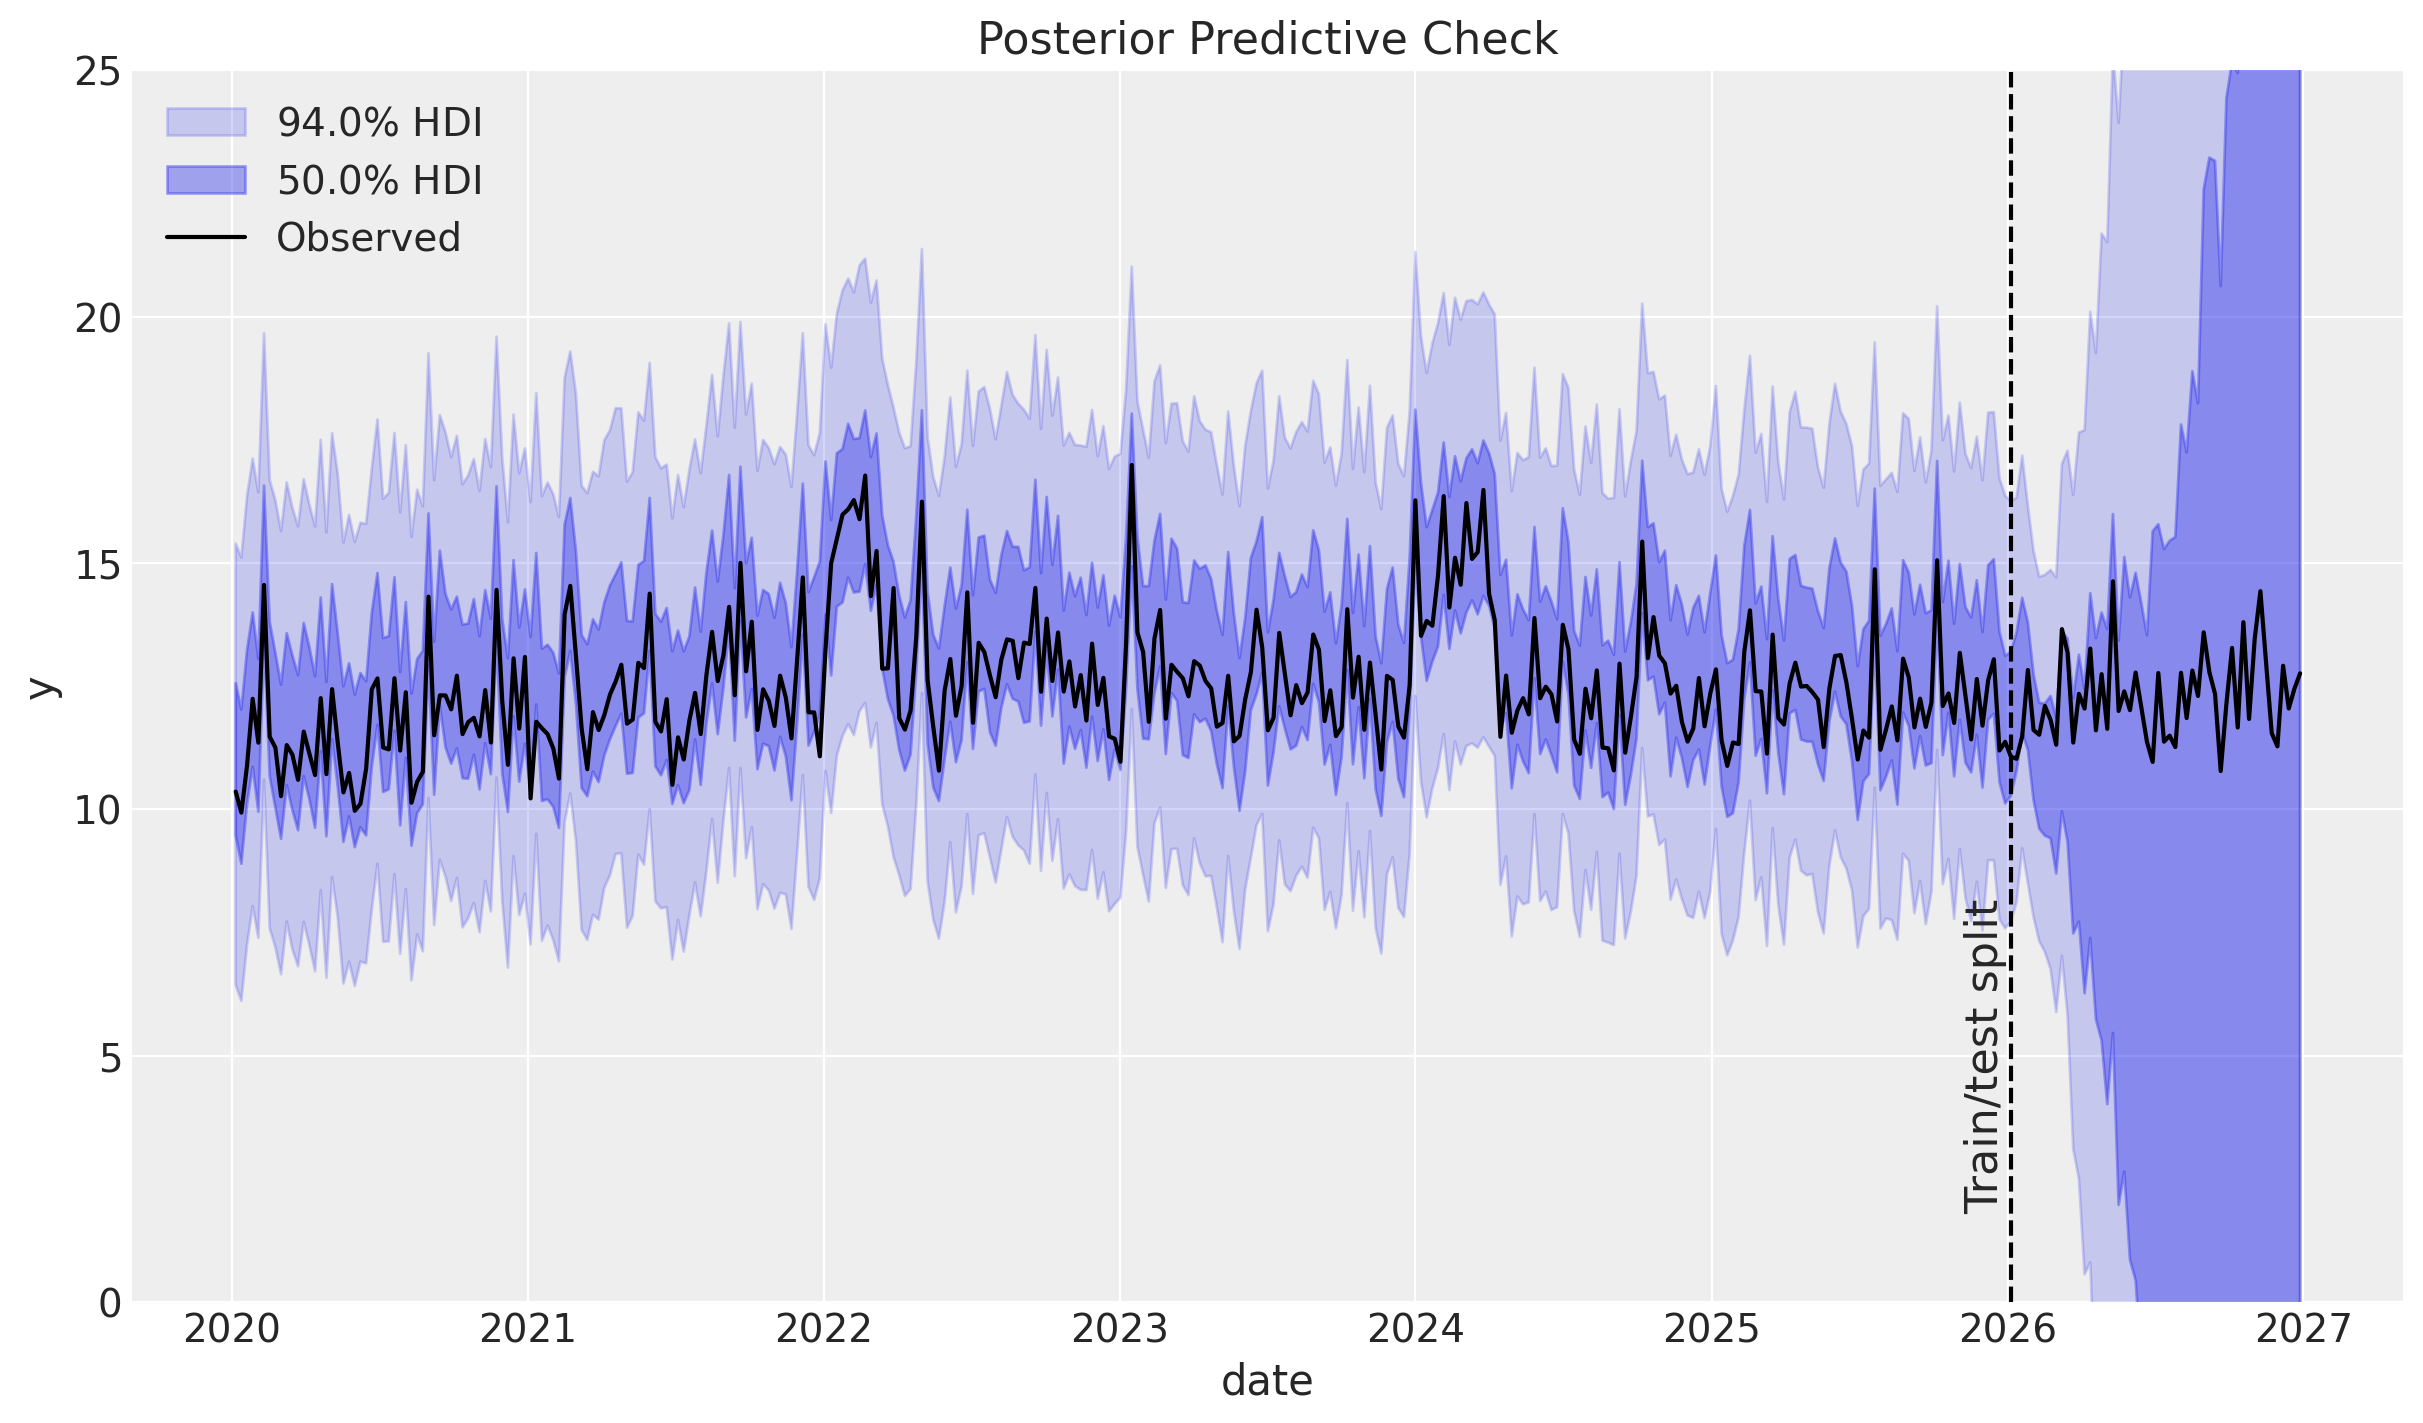

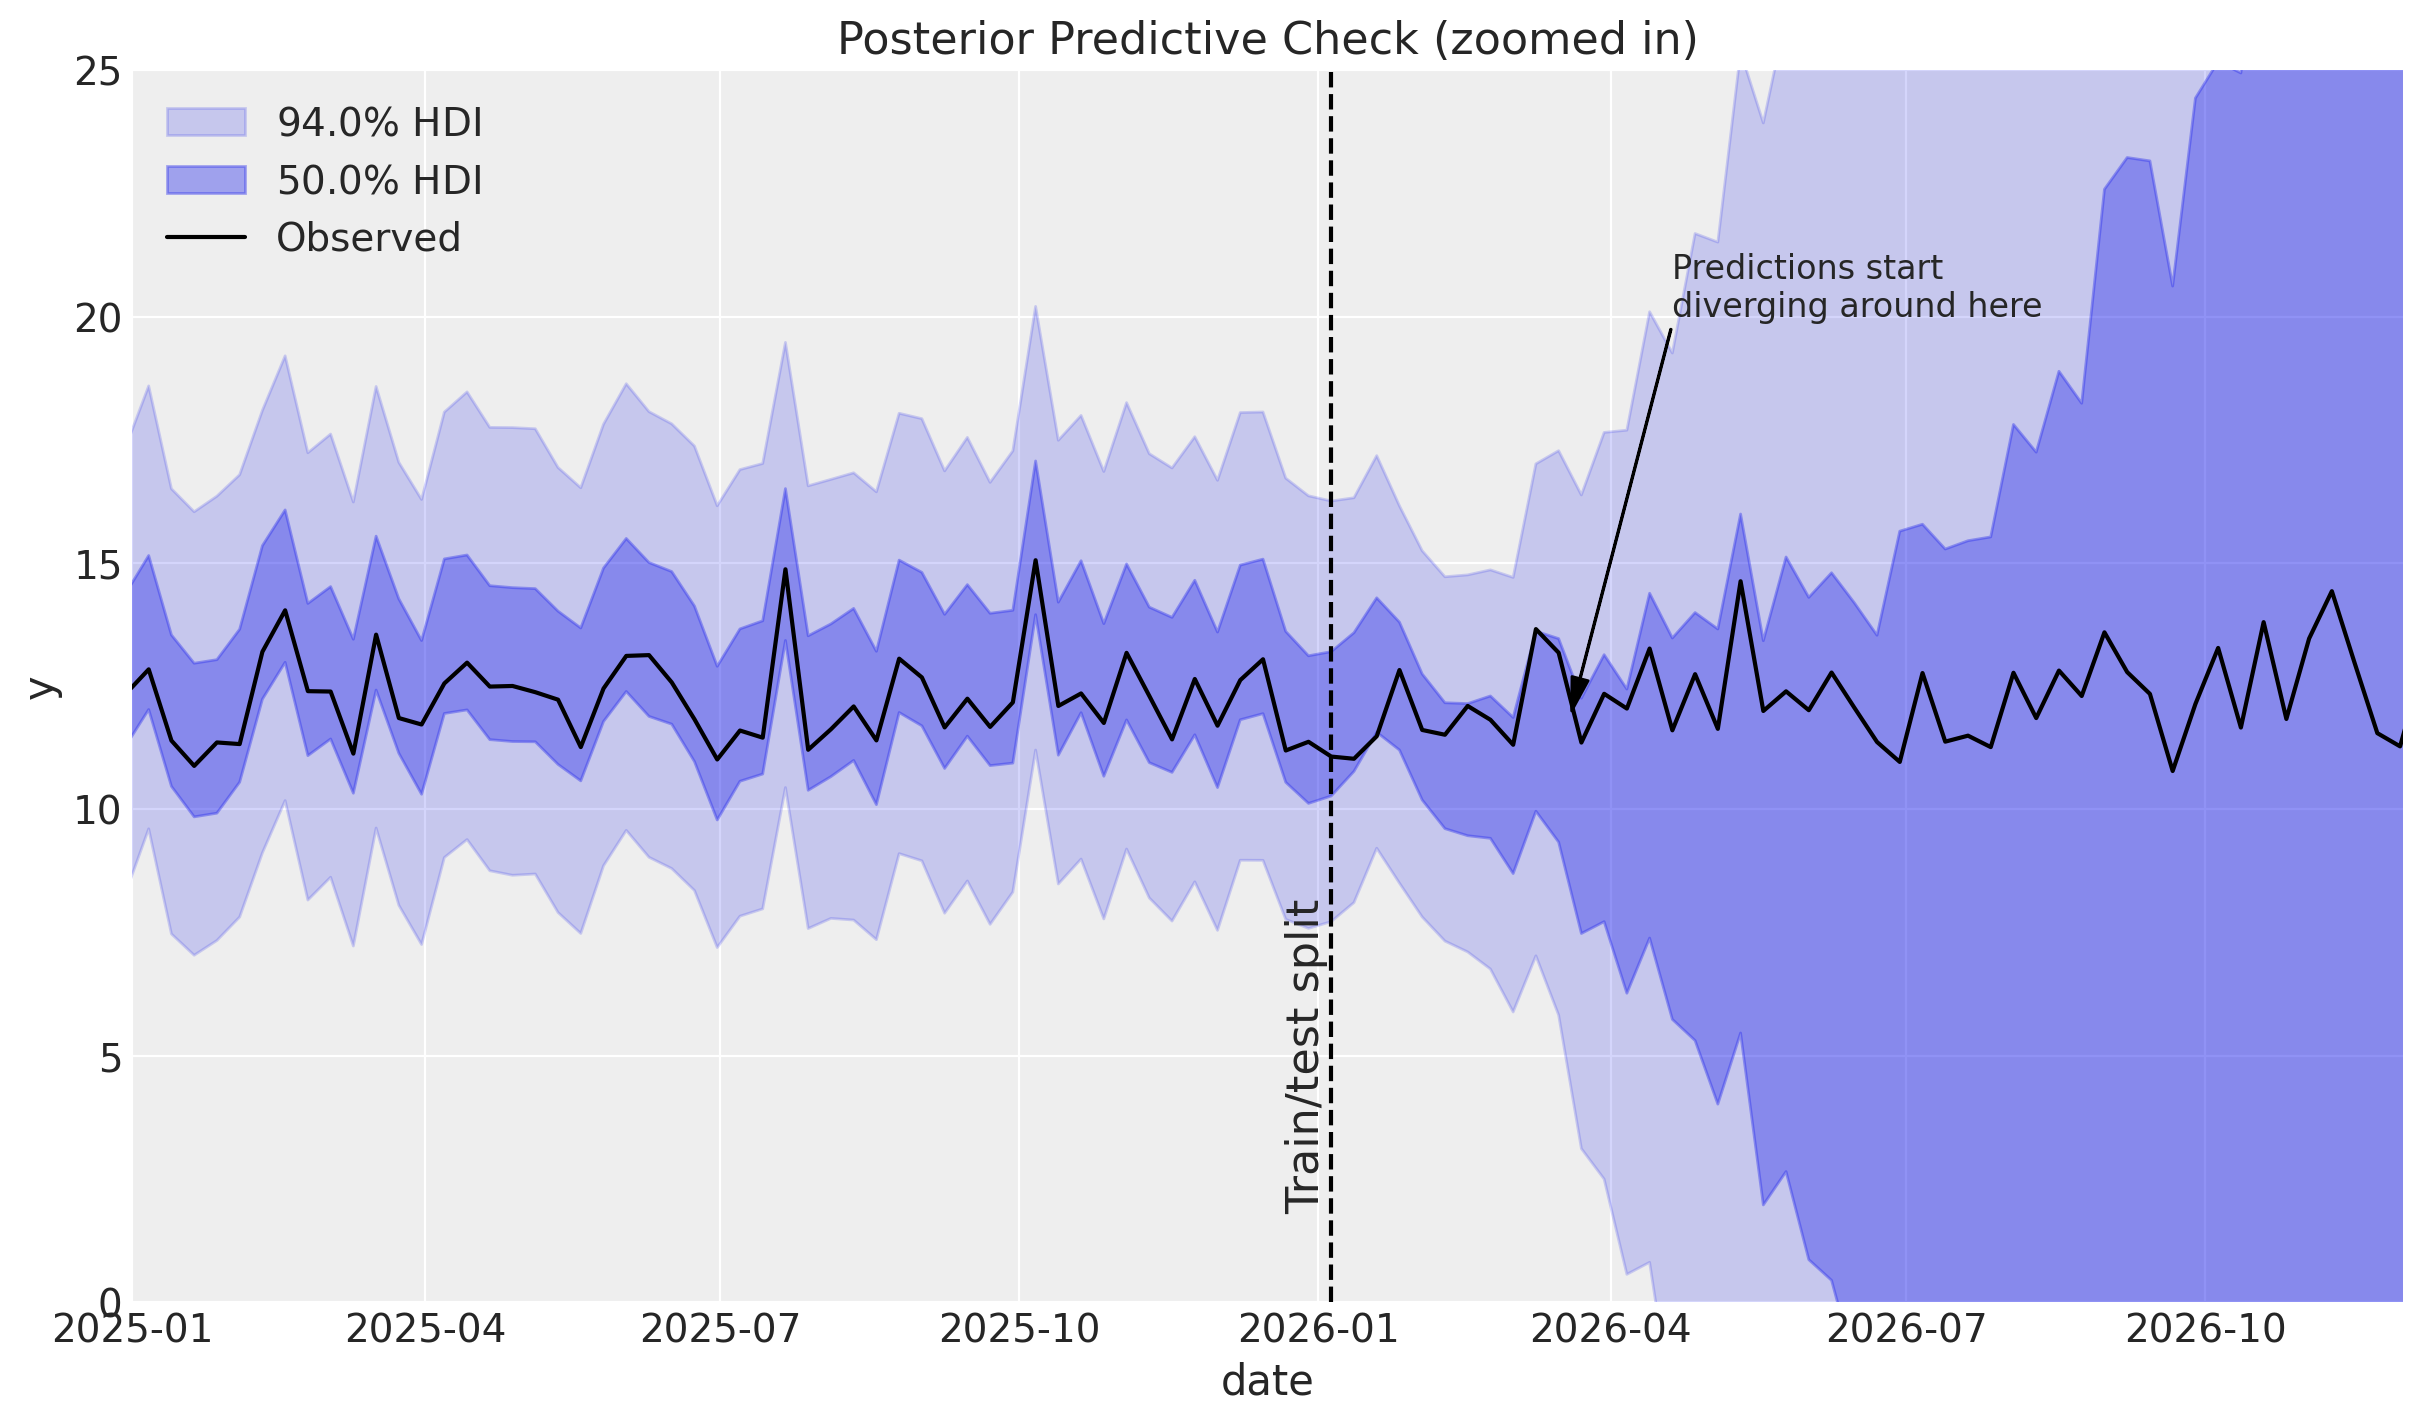

In [19]:
# Plot whole period
ax = plot_posterior_predictive(mmm_events, DATA["target_events"], label_y=5)
ax.set_ylim(0, 25)

# Zoom in on the years around train/test split
ax = plot_posterior_predictive_zoomed(
    mmm_events,
    DATA["target_events"],
    xlim=(date(2025, 1, 1), date(2026, 12, 1)),
    arrow_xy=(date(2026, 3, 20), 12),
    arrowtext_xy=(date(2026, 4, 20), 20),
    label_y=5
)
ax.set_ylim(0, 25);

Some observations:

- 👎 The model predictions have large uncertainty, more than observed in the previous examples.
- 💥 ~3 months into the out-of-sample set, uncertainty explodes.

**Predicting intercept**


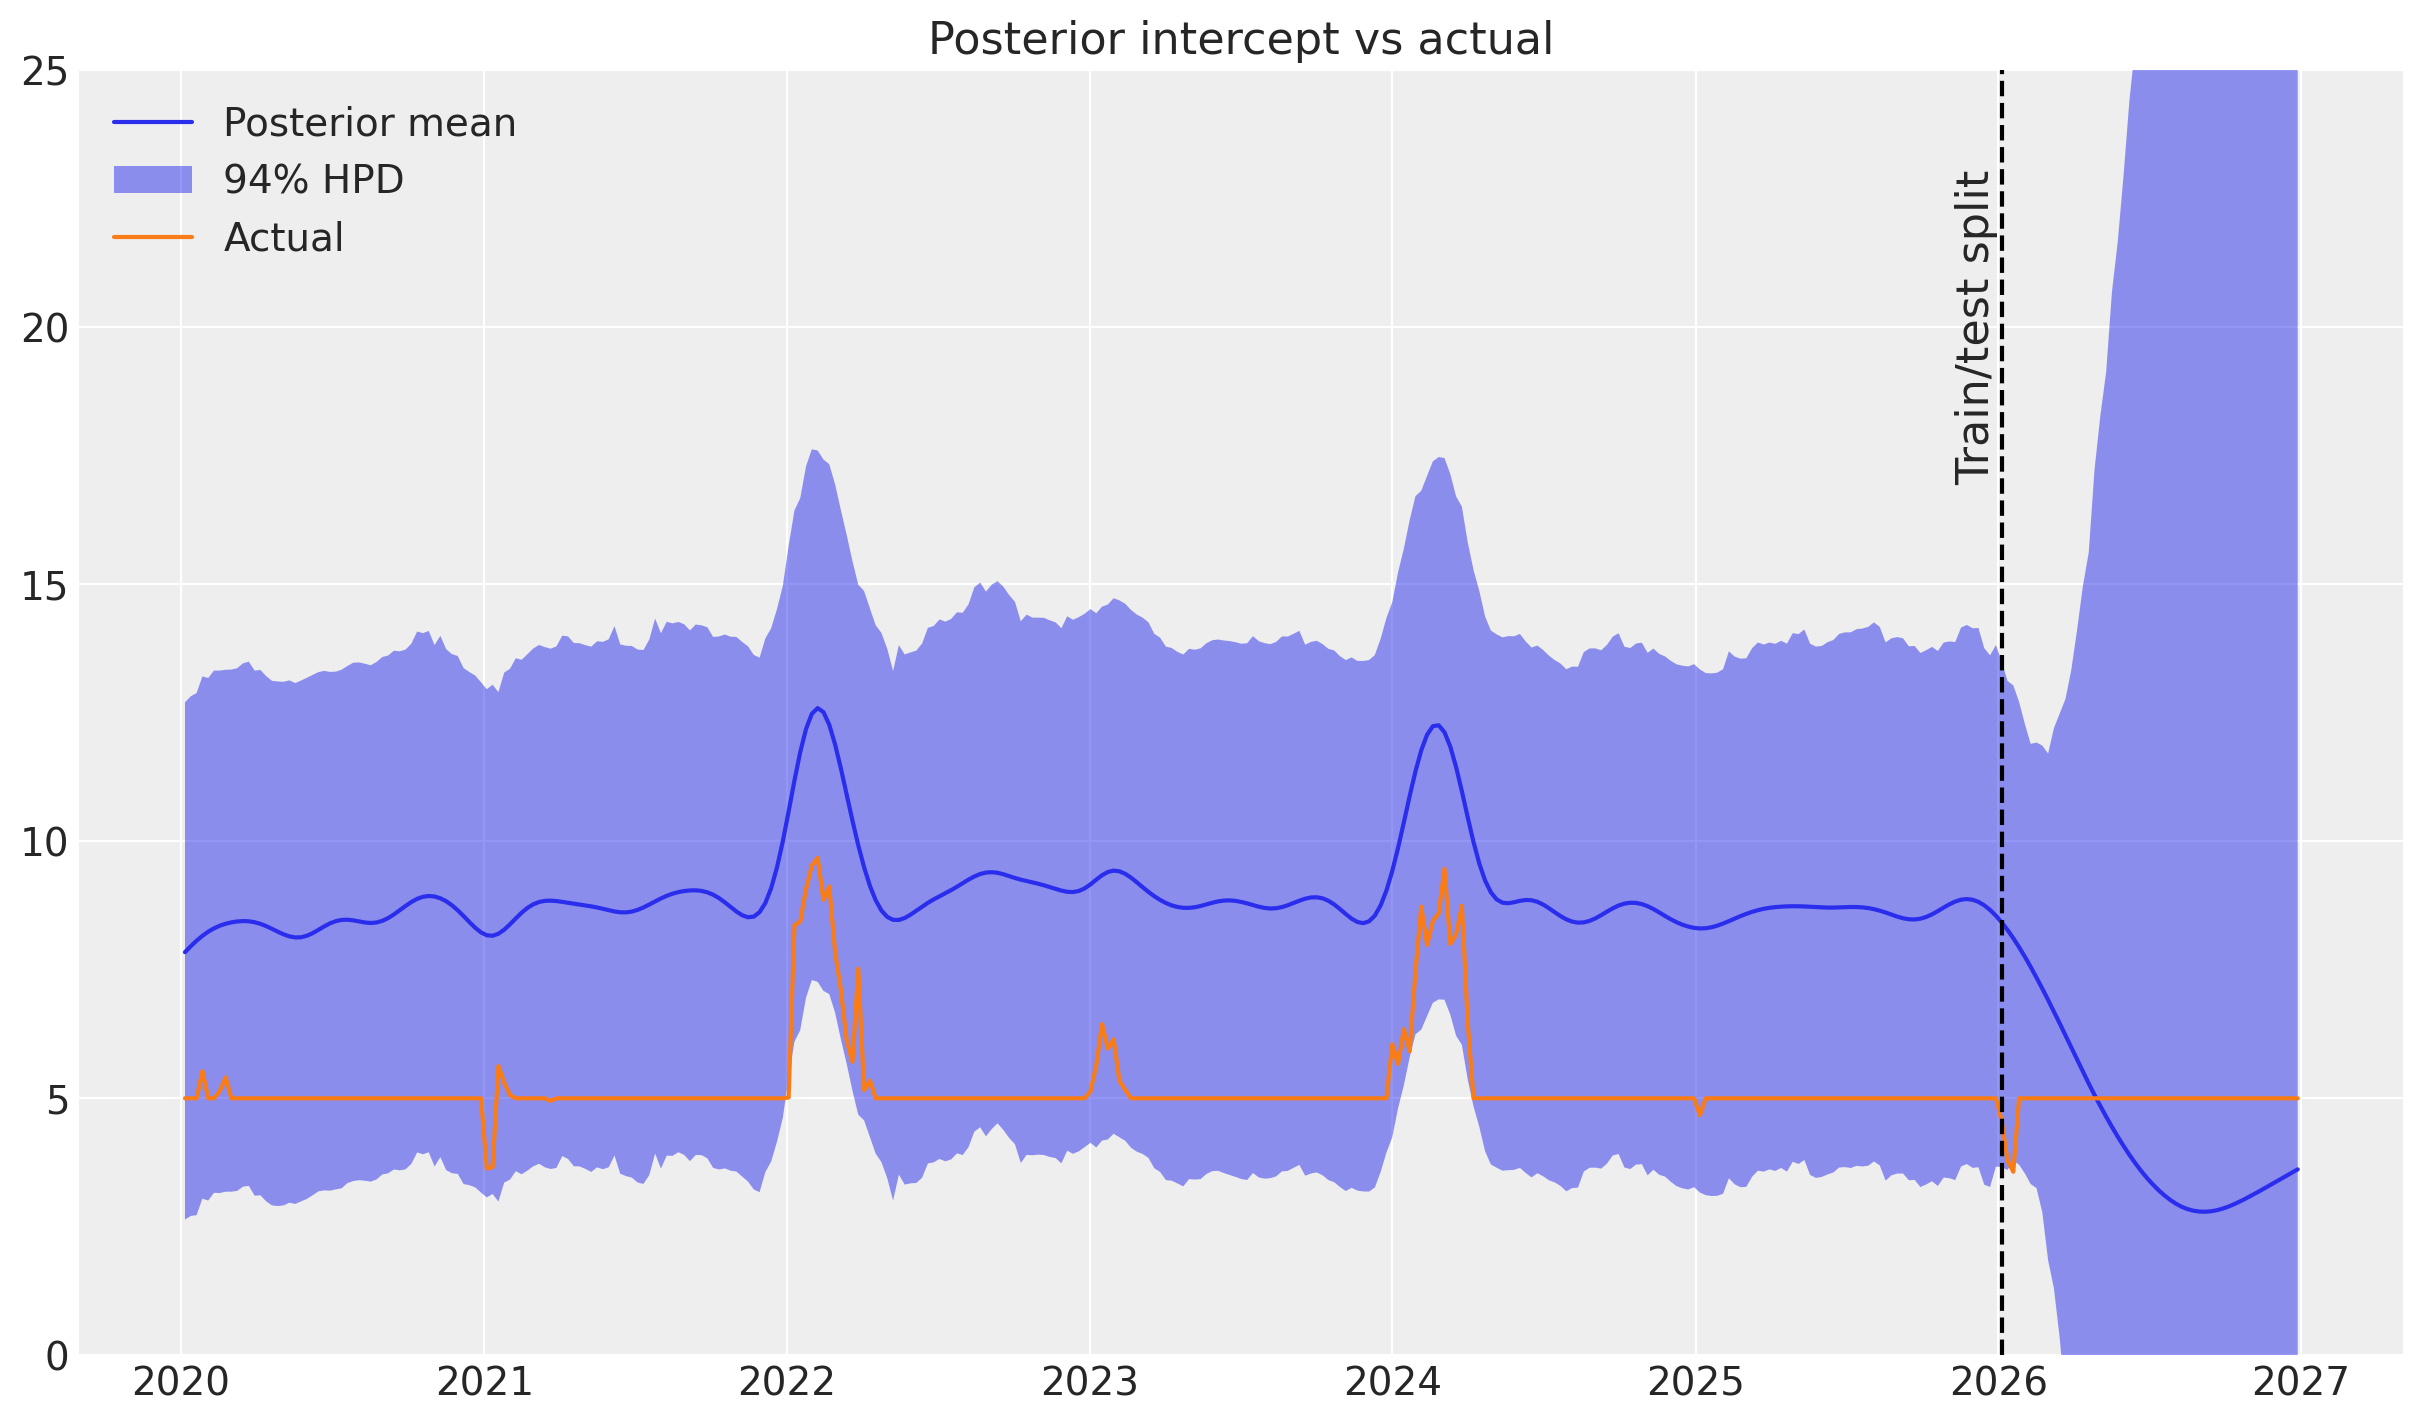

In [20]:
ax = plot_intercept_posterior_predictive(mmm_events, synthetic_intercept_events, label_y=20)
ax.set_ylim(0, 25);

In [21]:
print_base_intercept(mmm_events)

base_intercept: 8.32281084577989


Judging from the posterior predictive distribution of the time-varying intercept, there is a problem with the model.

We observe that:

- 👎 The model overestimates the intercept *a lot*.
- 🤷‍♂️ Only the two major events are captured by the time-varying intercept.
- 👎 Overall uncertainty is greater than in the previous examples.

This is a strong indication that the time-varying intercept prior may not be well parameterized. Since the events that we synthesize happen on shorter time scales than the trends we modeled previously, it is likely that the mean of the length-scale prior is too high (default is two years).


💡 Let's try to refit the model with a shorter length scale prior mean of one year (52.18 weeks).

In [22]:
mmm_events_short_ls = DelayedSaturatedMMM(
    date_column="Weeks",
    channel_columns=COORDS["media"],
    control_columns=COORDS["control"],
    adstock_max_lag=10,
    time_varying_intercept=True,
    sampler_config={
        "chains": 2,
        "draws": 2000,
        "tune": 500,
        "nuts_sampler": "numpyro",
    },
)
mmm_events_short_ls.model_config["intercept_tvp_config"]["ls_mu"] = 52.18
mmm_events_short_ls.model_config["intercept"]["dist"] = "HalfNormal"
mmm_events_short_ls.model_config["intercept"]["kwargs"] = {"sigma": 5}
mmm_events_short_ls.fit(data_train, data_train["target_events"]);

Running chain 1: 100%|██████████| 2500/2500 [01:22<00:00, 30.24it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Notice ☝️ fewer divergences 👌.

Sampling: [y]


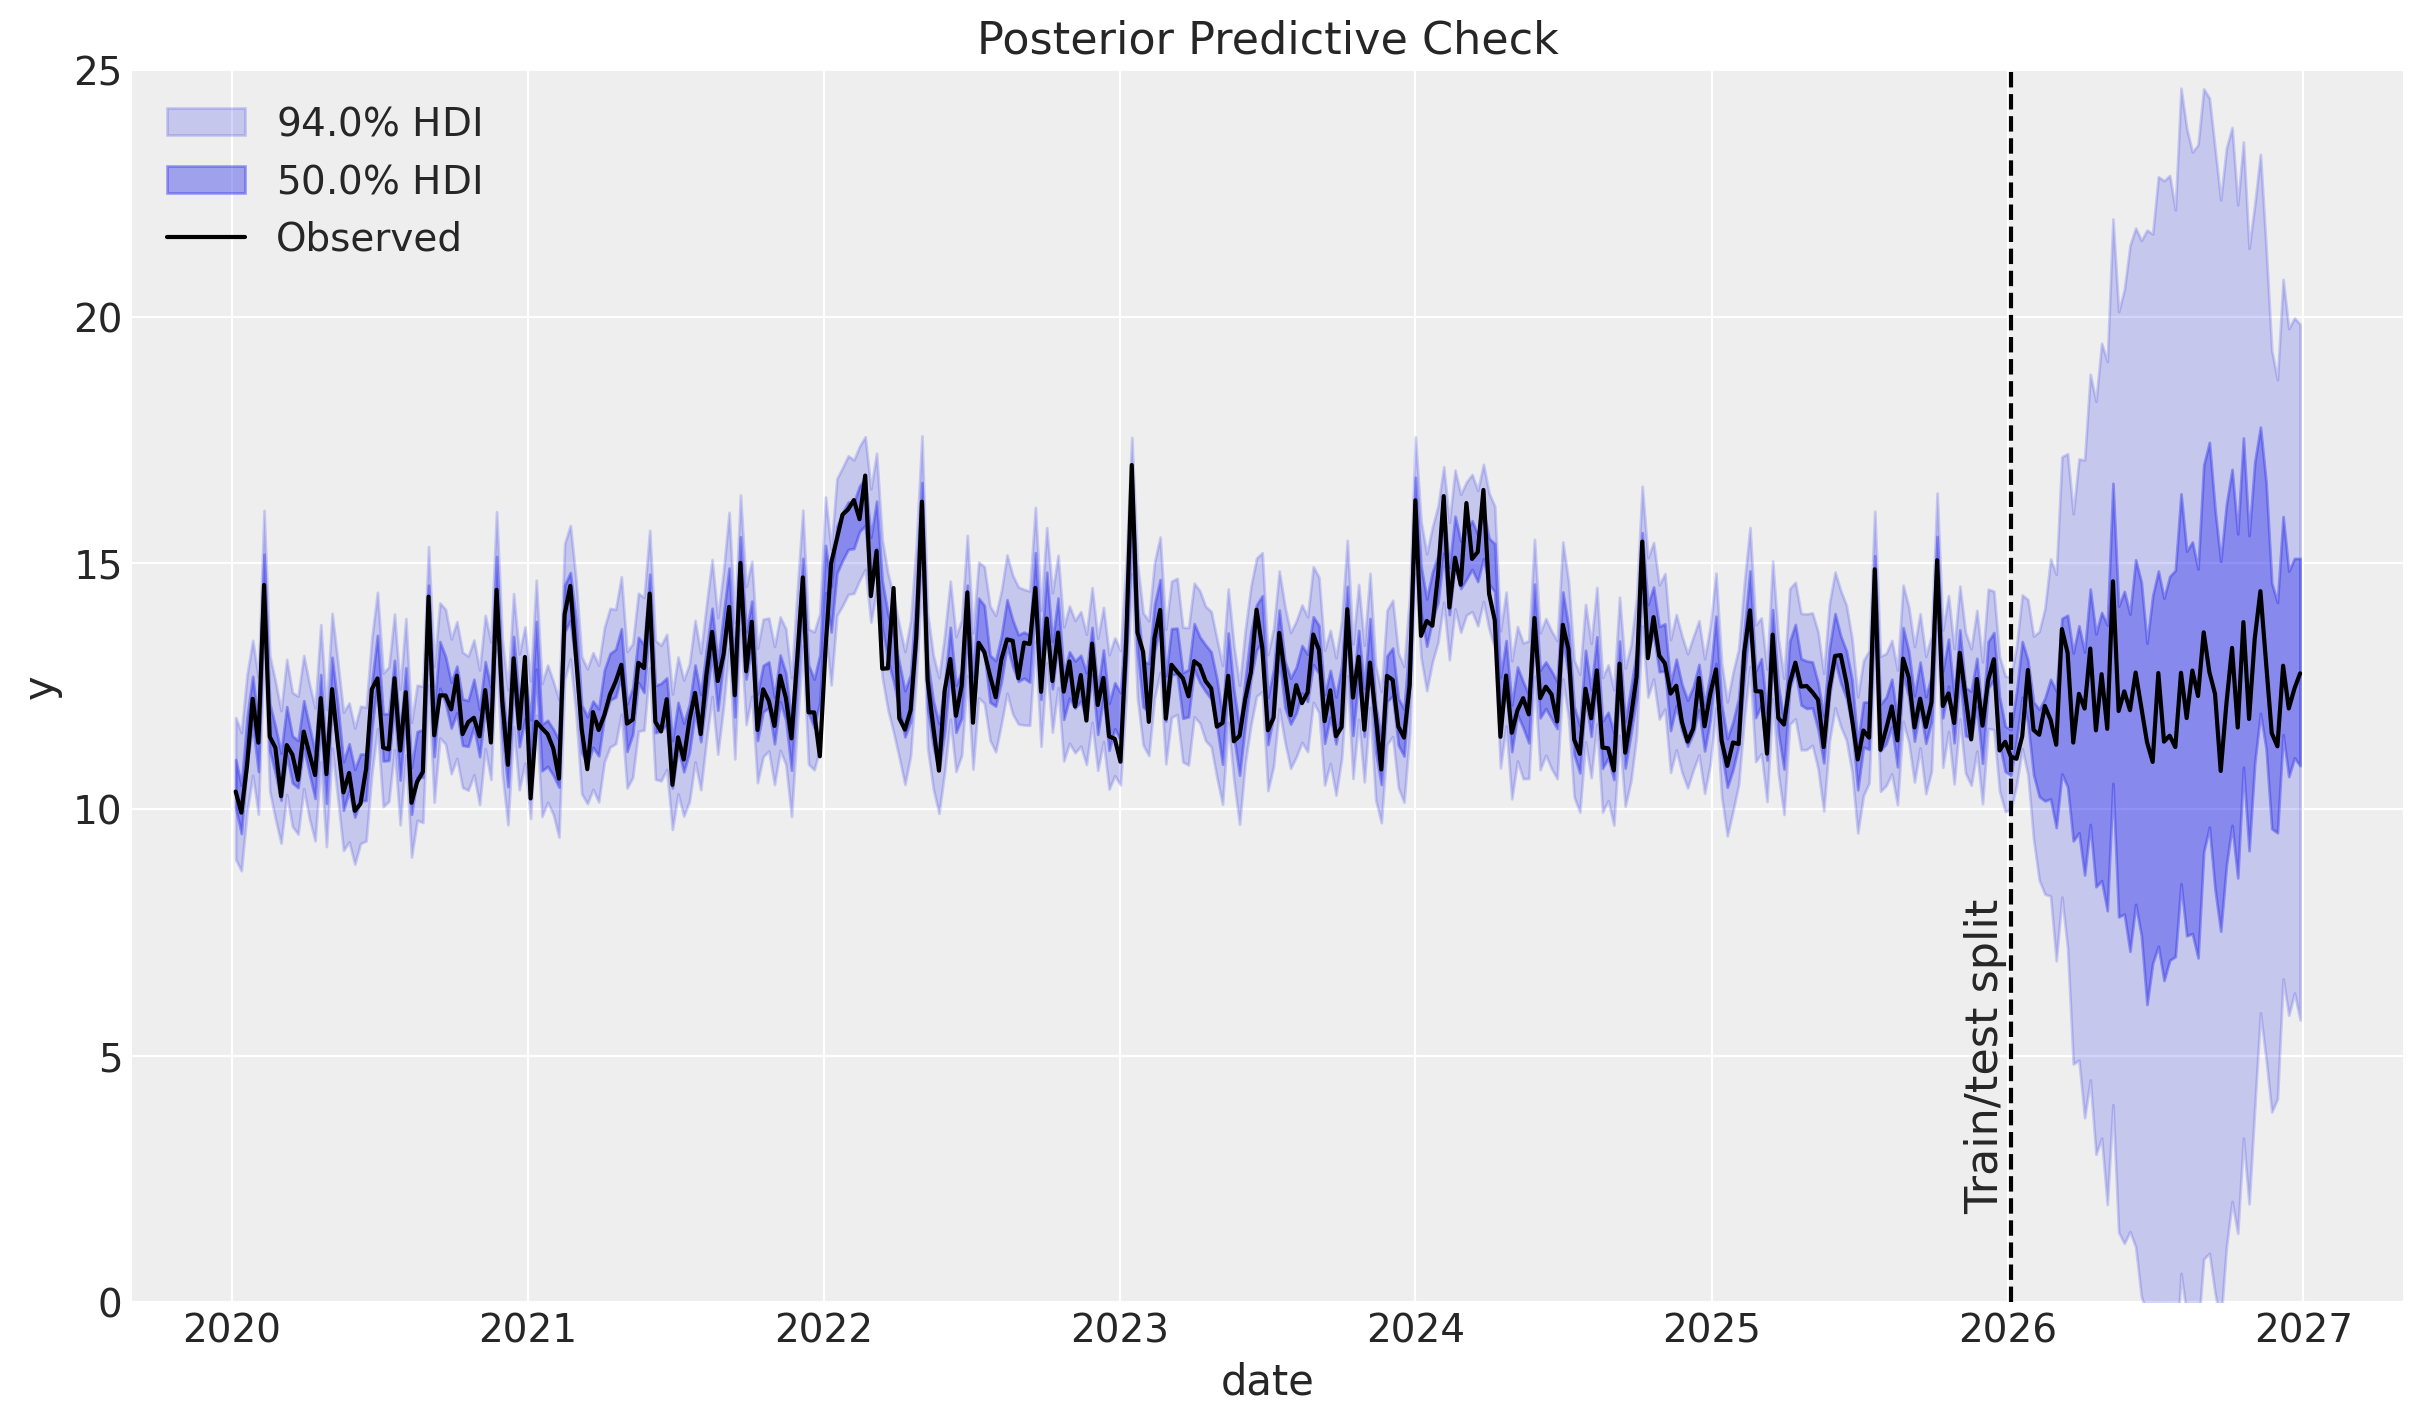

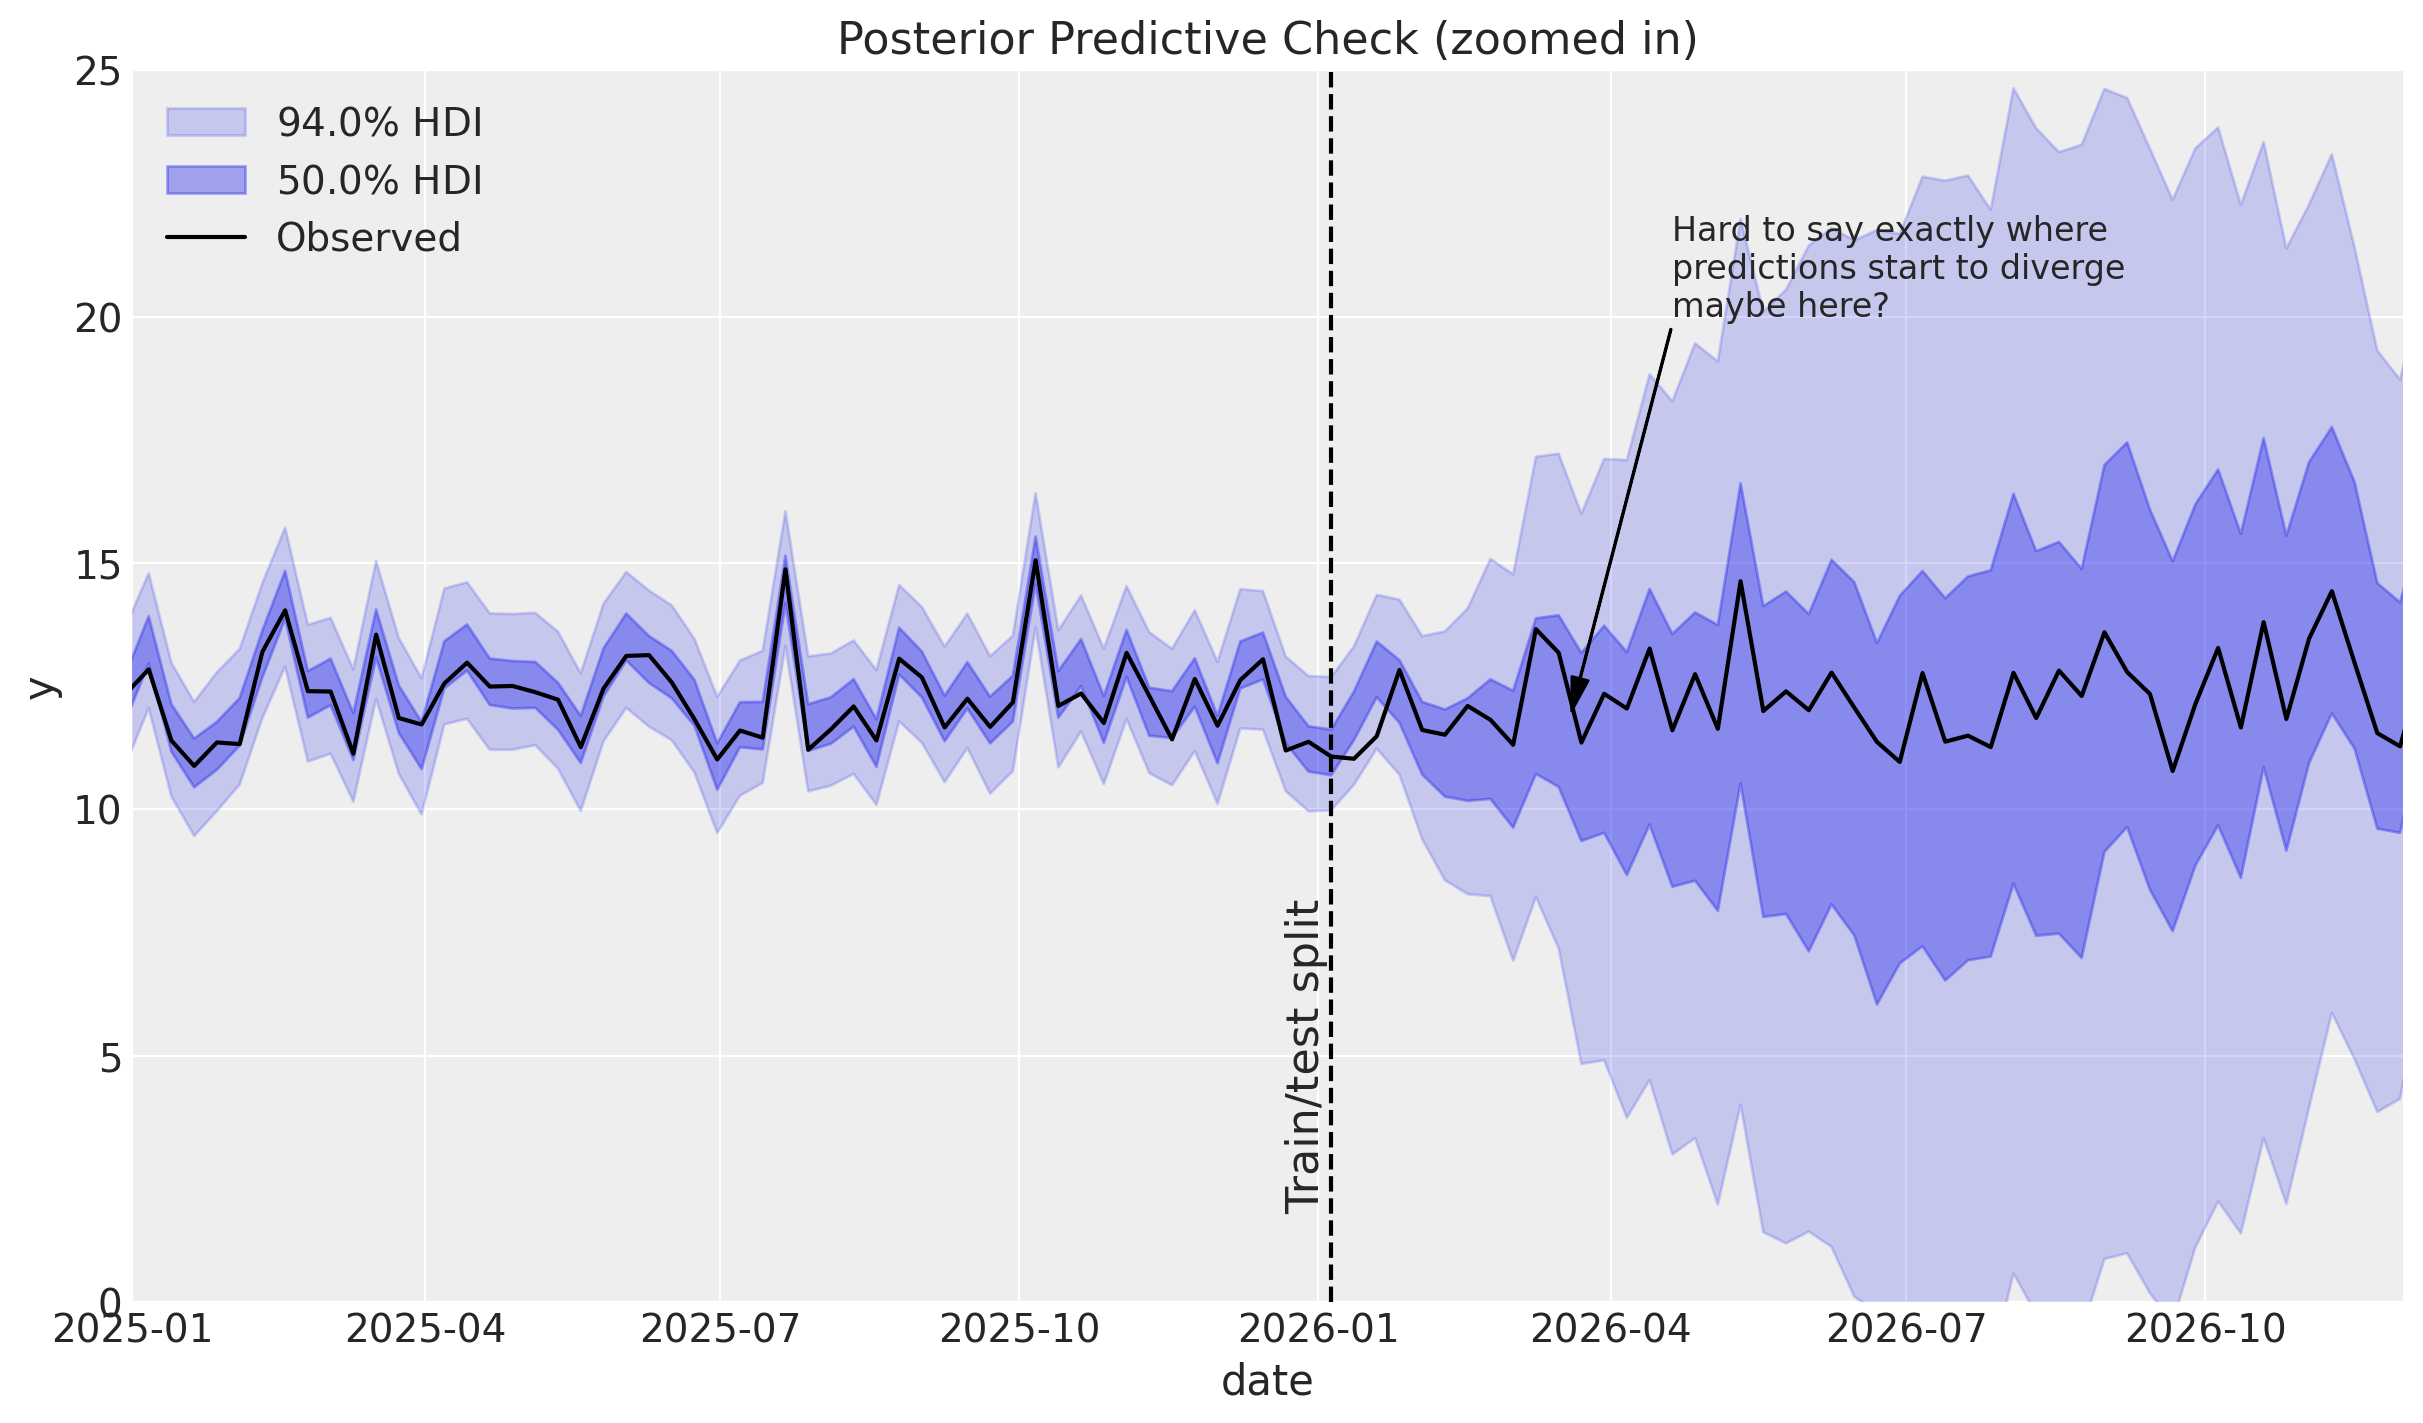

In [23]:
# Plot whole period
ax = plot_posterior_predictive(mmm_events_short_ls, DATA["target_events"], label_y=5)
ax.set_ylim(0, 25)

# Zoom in on the years around train/test split
ax = plot_posterior_predictive_zoomed(
    mmm_events_short_ls,
    DATA["target_events"],
    xlim=(date(2025, 1, 1), date(2026, 12, 1)),
    arrow_xy=(date(2026, 3, 20), 12),
    arrowtext_xy=(date(2026, 4, 20), 20),
    label_y=5,
    annotation_text="Hard to say exactly where\npredictions start to diverge\nmaybe here?"
)
ax.set_ylim(0, 25);

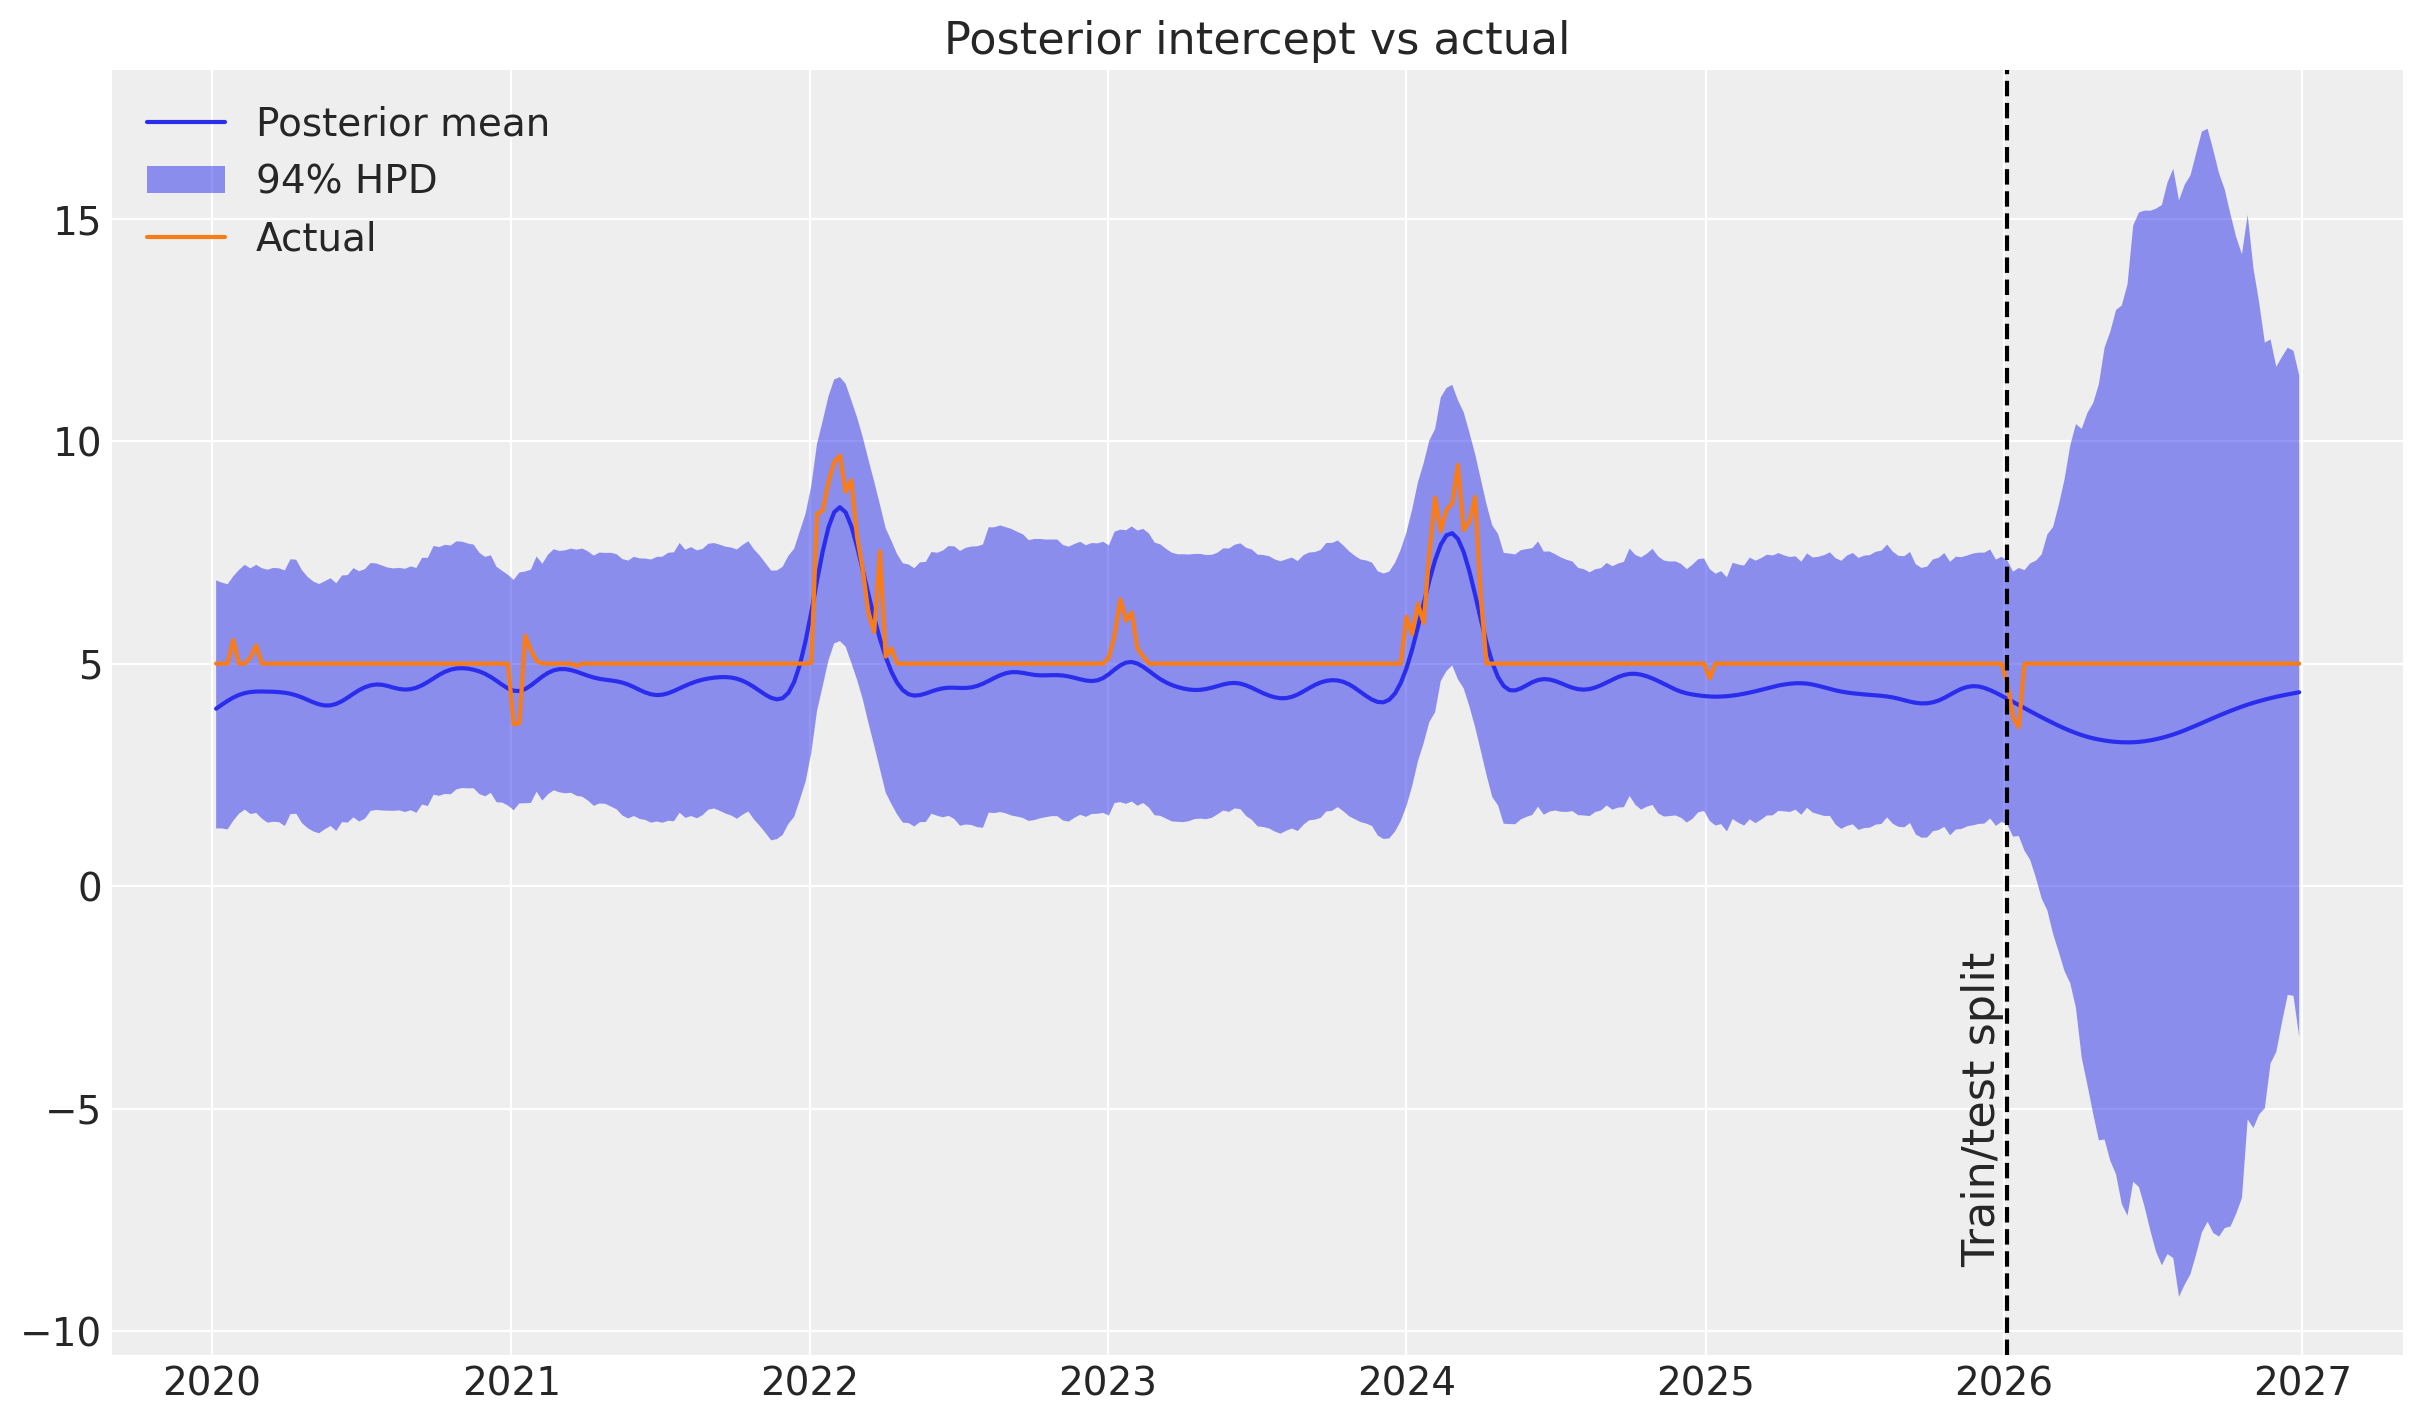

In [24]:
plot_intercept_posterior_predictive(mmm_events_short_ls, synthetic_intercept_events, label_y=-5);

In [25]:
print_base_intercept(mmm_events_short_ls)

base_intercept: 4.573866918891443


🎉 Success! As hypothesized, the time-varying intercept now captures the events better, and at the right scale! Notice how lowering the length-scale prior mean from the default two years to one year makes the series more _squiggly_.

*Sidenote: While the very-small events are still not captured perfectly, this may be remedied with a more complex covariance function supplied through the `model_config`, although these events are likely below the minimal detectable effect size in this example.*


## Conclusion

In this notebook, we have demonstrated how to use a time-varying parameter in a marketing mix model using `pymc-marketing`. We have shown how the model can capture yearly seasonality (with moderate success 🤷‍♂️), upward trending sales (not very well 👎), and random/unexpected events (very well 🎉). In summary, we show that a time-varying intercept, as modeled using a Gaussian Process (GP), is highly appropriate for modeling *random events* that cannot otherwise be accounted for in the model, whereas regular patterns that may influence baseline sales such as seasonality and constant demand increase are better modeled using a Fourier or linear basis.

**In a nutshell**

GPs are great at capturing patterns that are not easy/possible to extrapolate, and in turn, they cannot well extrapolate simple patterns like seasonality or increasing trends. For such cases, a Fourier basis or similar might be more appropriate. However, for explaining temporal variance that no other model component can account for—like the impact of an unexpected event—a time-varying intercept is great!

**When should I use a time-varying intercept?**

If you suspect that your baseline sales fluctuate over time due to factors beyond seasonality, constant growth, or explicitly modeled controls, consider using a time-varying parameter. The time-varying intercept is like a _catch-all_ for unexplained variance in your sales data.

**How should I parameterize my time-varying component?**

We have defined some sensible defaults, and in most cases, they are adequate. But if you have unexplained variance in your sales that occur on short time scales, you may—as in the example above—experiment with lowering the length-scale prior mean. If you need greater fidelity in the frequencies that the GP can capture, and can live with longer sampling times, you can also increase the number of basis functions `model_config['intercept_tvp_config']['m']` from 200 (default) to a higher number. Finally, if you believe you have events affecting your sales on, say, two separate time scales, you can supply a new covariance function through `model_config['intercept_tvp_config']['cov_func']`, which is *the sum of two independently defined covariance functions*—each with a length-scale prior mean that matches the given time scales you expect in your data.


In [27]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Fri Jun 21 2024

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.25.0

pytensor: 2.22.1

arviz     : 0.18.0
pymc      : 5.15.1
numpy     : 1.26.4
matplotlib: 3.9.0
pandas    : 2.2.2

Watermark: 2.4.3

